In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sagemaker
from sagemaker import Session
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/vaishnavivishwasmane/Library/Application Support/sagemaker/config.yaml


In [3]:
sm_boto3 = boto3.client ("sagemaker")
sess = sagemaker. Session ()
region = sess. boto_session. region_name
bucket = 'thyroidsagemakerbucket' # Mention the created S3 bucket name here
print("Using bucket " + bucket)

Using bucket thyroidsagemakerbucket


# Import Dataset

In [4]:
df=pd.read_csv('thyroidDF.csv')
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


# Data Preprocessing

In [12]:
df.dtypes

age                      int64
sex                     object
on_thyroxine            object
query_on_thyroxine      object
on_antithyroid_meds     object
sick                    object
pregnant                object
thyroid_surgery         object
I131_treatment          object
query_hypothyroid       object
query_hyperthyroid      object
lithium                 object
goitre                  object
tumor                   object
hypopituitary           object
psych                   object
TSH_measured            object
TSH                    float64
T3_measured             object
T3                     float64
TT4_measured            object
TT4                    float64
T4U_measured            object
T4U                    float64
FTI_measured            object
FTI                    float64
TBG_measured            object
TBG                    float64
referral_source         object
target                  object
patient_id               int64
dtype: object

### Drop unnecessary columns

In [13]:
df.isnull().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [14]:
# Dropped 7 cols here
df=df.drop(columns=['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis=1)

In [15]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9172.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000,9.172000e+03
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,8.529473e+08
std,1183.976718,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504,7.581969e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,8.510040e+08
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000,8.607110e+08
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


In [16]:
df.isnull().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH                     842
T3                     2604
TT4                     442
T4U                     809
FTI                     802
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

## Looking at NAN values and age range


In [17]:
# Filtering rows where 'age' column has values > 100
# All the rows with age greater than 100 have target variable as no condition. Hence dropping the 3 columns.
age_greater_than_100 = df[df['age'] > 100]  

In [18]:
# Dropping rows from df where age > 100
df=df[df['age'] <= 100]

In [19]:
# Replacing null values in 'sex' column with the mode (most frequent value)
df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df.head(25)

/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_31627/1561482013.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].fillna(df['sex'].mode()[0], inplace=True)


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,f,0.30,NaN,NaN,NaN,NaN,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,f,1.60,1.9,128.0,NaN,NaN,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,36.0,other,S,840803047
5,60,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,26.0,other,-,840803048
6,77,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,21.0,other,-,840803068
7,28,F,f,f,f,f,f,f,f,f,...,f,0.70,2.6,116.0,NaN,NaN,NaN,SVI,-,840807019
8,28,F,f,f,f,f,f,f,f,f,...,f,1.20,1.8,76.0,NaN,NaN,NaN,other,-,840808060
9,28,F,f,f,f,f,f,f,f,f,...,f,1.90,1.7,83.0,NaN,NaN,NaN,other,-,840808073


In [20]:
# Finding Null values in sex column
null_sex_rows = df[df['sex'].isnull()]
target_counts = null_sex_rows['target'].value_counts()
target_counts

Series([], Name: count, dtype: int64)

In [21]:
import pandas as pd

# Define the replacement values based on age and gender
replacement_values = {
    (1, 9, 'M'): 3.75, (1, 9, 'F'): 3.75,
    (10, 19, 'M'): 3.35, (10, 19, 'F'): 3.35,
    (20 ,100 , 'M'): 1.85, (20, 100, 'F'): 2.2
}

# Define a function to replace null values based on age and gender
def replace_tbg_null(row):
    age = row['age']
    gender = row['sex']
    if pd.isnull(row['TBG']):
        if age >= 1 and age <= 9:
            return replacement_values[(1, 9, gender)]
        elif age >= 10 and age <= 19:
            return replacement_values[(10, 19, gender)]
        else:
            return replacement_values[(20, 100, gender)]
    else:
        return row['TBG']

# Apply the function to replace null values in the TBG column
df['TBG'] = df.apply(replace_tbg_null, axis=1)

In [22]:
df.reset_index(drop=True, inplace=True)
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,f,0.3,NaN,NaN,NaN,NaN,2.20,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,f,1.6,1.9,128.0,NaN,NaN,2.20,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,11.00,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,26.00,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,36.00,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,56,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,64.0,0.83,77.0,1.85,SVI,-,870119022
9164,22,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,91.0,0.92,99.0,1.85,SVI,-,870119023
9165,69,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,113.0,1.27,89.0,1.85,SVI,I,870119025
9166,47,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,75.0,0.85,88.0,2.20,other,-,870119027


In [23]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9168.000000,8326.000000,6565.000000,8726.000000,8359.000000,8366.000000,9168.000000,9.168000e+03
mean,52.099695,5.220548,1.970494,108.695698,0.976036,113.638900,3.199945,8.529451e+08
std,18.910296,24.189614,0.887722,37.530264,0.200392,41.560437,6.716346,7.582333e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.462500,1.500000,87.000000,0.860000,93.000000,1.850000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,2.200000,8.510040e+08
75%,67.000000,2.700000,2.300000,126.000000,1.060000,128.000000,2.200000,8.607110e+08
max,97.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


## Mapping of target column with corresponding classes

In [24]:
# Mapping dictionary based on provided mapping
mapping = {
    'A': 'Hyperthyroid', 'B': 'Hyperthyroid', 'C': 'Hyperthyroid', 'D': 'Hyperthyroid', 'AK': 'Hyperthyroid',
    'E': 'Hypothyroid', 'F': 'Hypothyroid', 'G': 'Hypothyroid', 'H': 'Hypothyroid', 'GK': 'Hypothyroid',
    'GI': 'Hypothyroid', 'FK': 'Hypothyroid', 'GKJ': 'Hypothyroid',
    'I': 'Binding Protein', 'J': 'Binding Protein', 'C|I': 'Binding Protein',
    'K': 'General Health', 'KJ': 'General Health', 'H|K': 'General Health',
    'M': 'Replacement Therapy', 'L': 'Replacement Therapy', 'N': 'Replacement Therapy',
    'MK': 'Replacement Therapy', 'MI': 'Replacement Therapy', 'LJ': 'Replacement Therapy',
    # 'O': 'Antithyroid Treatment', 'P': 'Antithyroid Treatment', 'Q': 'Antithyroid Treatment', 'OI': 'Antithyroid Treatment',
    'O': 'Miscellaneous', 'P': 'Miscellaneous', 'Q': 'Miscellaneous', 'OI': 'Miscellaneous',
    'R': 'Miscellaneous', 'S': 'Miscellaneous', 'T': 'Miscellaneous', 'D|R': 'Miscellaneous',
    '-': 'No Condition'
}

# Creating a new column based on the mapping
df['class'] = df['target'].map(mapping)

In [25]:
# Creating a new Patient_ID column with unique IDs
df['Patient_ID']=df.index+1

In [26]:
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id,class,Patient_ID
0,29,F,f,f,f,f,f,f,f,t,...,NaN,NaN,NaN,NaN,2.20,other,-,840801013,No Condition,1
1,29,F,f,f,f,f,f,f,f,f,...,1.9,128.0,NaN,NaN,2.20,other,-,840801014,No Condition,2
2,41,F,f,f,f,f,f,f,f,f,...,NaN,NaN,NaN,NaN,11.00,other,-,840801042,No Condition,3
3,36,F,f,f,f,f,f,f,f,f,...,NaN,NaN,NaN,NaN,26.00,other,-,840803046,No Condition,4
4,32,F,f,f,f,f,f,f,f,f,...,NaN,NaN,NaN,NaN,36.00,other,S,840803047,Miscellaneous,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,56,M,f,f,f,f,f,f,f,f,...,NaN,64.0,0.83,77.0,1.85,SVI,-,870119022,No Condition,9164
9164,22,M,f,f,f,f,f,f,f,f,...,NaN,91.0,0.92,99.0,1.85,SVI,-,870119023,No Condition,9165
9165,69,M,f,f,f,f,f,f,f,f,...,NaN,113.0,1.27,89.0,1.85,SVI,I,870119025,Binding Protein,9166
9166,47,F,f,f,f,f,f,f,f,f,...,NaN,75.0,0.85,88.0,2.20,other,-,870119027,No Condition,9167


In [27]:
# Dropping columns not requried
df.drop(columns=['target','patient_id'], axis=1, inplace=True)

In [28]:
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,class,Patient_ID
0,29,F,f,f,f,f,f,f,f,t,...,f,0.3,NaN,NaN,NaN,NaN,2.20,other,No Condition,1
1,29,F,f,f,f,f,f,f,f,f,...,f,1.6,1.9,128.0,NaN,NaN,2.20,other,No Condition,2
2,41,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,11.00,other,No Condition,3
3,36,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,26.00,other,No Condition,4
4,32,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,NaN,NaN,NaN,36.00,other,Miscellaneous,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9163,56,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,64.0,0.83,77.0,1.85,SVI,No Condition,9164
9164,22,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,91.0,0.92,99.0,1.85,SVI,No Condition,9165
9165,69,M,f,f,f,f,f,f,f,f,...,f,NaN,NaN,113.0,1.27,89.0,1.85,SVI,Binding Protein,9166
9166,47,F,f,f,f,f,f,f,f,f,...,f,NaN,NaN,75.0,0.85,88.0,2.20,other,No Condition,9167


In [29]:
print(df['class'].value_counts())

class
No Condition           6767
Hypothyroid             659
General Health          455
Binding Protein         388
Replacement Therapy     355
Miscellaneous           316
Hyperthyroid            228
Name: count, dtype: int64


In [30]:
#DRopping rows with NAN values for various features & class is 'No Condition'
rows_to_drop = df[(df['TSH'].isnull() | df['T3'].isnull() | df['TT4'].isnull() |
                   df['T4U'].isnull() | df['FTI'].isnull()) & (df['class'] == 'No Condition')]

# Drop the filtered rows from the DataFrame
df.drop(rows_to_drop.index, inplace=True)

In [31]:
rows_to_drop.shape

(2474, 25)

In [34]:
df.shape

(6697, 31)

In [30]:
print(df['class'].value_counts())

class
No Condition           4293
Hypothyroid             659
General Health          455
Binding Protein         388
Replacement Therapy     355
Miscellaneous           316
Hyperthyroid            228
Name: count, dtype: int64


In [31]:
print(df['class'].value_counts())

class
No Condition           4293
Hypothyroid             659
General Health          455
Binding Protein         388
Replacement Therapy     355
Miscellaneous           316
Hyperthyroid            228
Name: count, dtype: int64


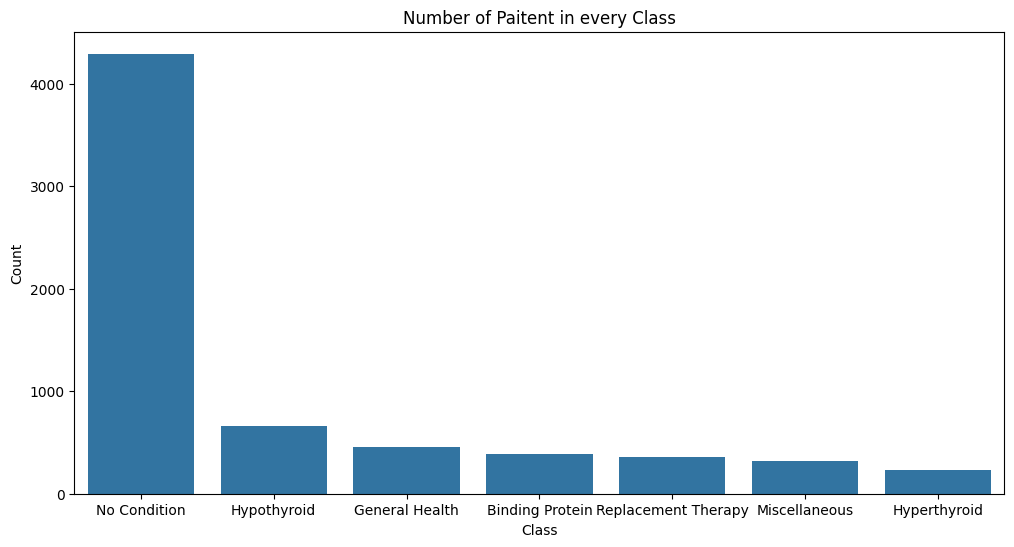

In [32]:
# Counting the number of patients in every Class
Class_counts = df['class'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=Class_counts.index, y=Class_counts.values)
plt.title('Number of Paitent in every Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Traning Part 1

NAN value for t3,tsh,t4

In [33]:
# Create a new DataFrame with relevant columns
df_1=df.copy()
df_fillna = df[['age', 'T3','TT4','TSH']]
df_fillna

,age,T3,TT4,TSH
4,32,NaN,NaN,NaN
18,63,NaN,48.0,68.00
19,36,2.4,90.0,1.50
21,40,2.3,104.0,1.20
22,40,2.1,88.0,5.90
...,...,...,...,...
9149,64,NaN,31.0,0.81
9153,60,NaN,28.0,0.18
9154,64,NaN,44.0,NaN
9158,36,NaN,84.0,NaN


In [34]:
# Create bins for age groups and calculate average T3 for each group
df_fillna['age_group'] = pd.cut(df_fillna['age'], bins=10)
average_t3_by_age_group = df_fillna.groupby('age_group')['T3'].mean()
average_t4_by_age_group = df_fillna.groupby('age_group')['TT4'].mean()
average_tsh_by_age_group = df_fillna.groupby('age_group')['TSH'].mean()


/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_20052/582030837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fillna['age_group'] = pd.cut(df_fillna['age'], bins=10)
/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_20052/582030837.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_t3_by_age_group = df_fillna.groupby('age_group')['T3'].mean()
/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_20052/582030837.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

In [35]:
df_1['age_group'] = pd.cut(df_1['age'], bins=10)
df_1 = pd.merge(df_1, average_t3_by_age_group, on='age_group', how='left')
df_1 = pd.merge(df_1, average_t4_by_age_group, on='age_group', how='left')
df_1 = pd.merge(df_1, average_tsh_by_age_group, on='age_group', how='left')\

# Fill null values in 'T3' with the corresponding average for each age bin
df_1['T3_x'] = df_1.apply(lambda row: row['T3_y'] if pd.isnull(row['T3_x']) else row['T3_x'], axis=1)
df_1['TT4_x'] = df_1.apply(lambda row: row['TT4_y'] if pd.isnull(row['TT4_x']) else row['TT4_x'], axis=1)
df_1['TSH_x'] = df_1.apply(lambda row: row['TSH_y'] if pd.isnull(row['TSH_x']) else row['TSH_x'], axis=1)

#Drop T3_y
df_1.drop(columns=['T3_y','TT4_y','TSH_y'], axis=1, inplace=True)

In [36]:
df_1

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH_x,T3_x,TT4_x,T4U,FTI,TBG,referral_source,class,Patient_ID,age_group
0,32,F,f,f,f,f,f,f,f,f,...,4.948343,2.232518,115.182155,NaN,NaN,36.00,other,Miscellaneous,5,"(29.8, 39.4]"
1,63,F,t,f,f,t,f,f,f,f,...,68.000000,1.853211,48.000000,1.02,47.0,2.20,other,Hypothyroid,19,"(58.6, 68.2]"
2,36,F,f,f,f,f,f,f,f,t,...,1.500000,2.400000,90.000000,1.06,85.0,2.20,other,No Condition,20,"(29.8, 39.4]"
3,40,F,f,f,f,f,f,f,f,f,...,1.200000,2.300000,104.000000,1.08,96.0,2.20,other,No Condition,22,"(39.4, 49.0]"
4,40,F,f,f,f,f,f,f,f,f,...,5.900000,2.100000,88.000000,0.84,105.0,2.20,other,No Condition,23,"(39.4, 49.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,64,M,f,f,f,f,f,f,f,f,...,0.810000,1.853211,31.000000,0.55,56.0,1.85,SVI,General Health,9150,"(58.6, 68.2]"
6690,60,M,f,f,t,f,f,f,f,f,...,0.180000,1.853211,28.000000,0.87,32.0,1.85,other,General Health,9154,"(58.6, 68.2]"
6691,64,M,f,f,f,f,f,f,f,t,...,6.925247,1.853211,44.000000,0.53,83.0,1.85,other,Binding Protein,9155,"(58.6, 68.2]"
6692,36,F,f,f,f,f,f,f,f,f,...,4.948343,2.232518,84.000000,1.26,67.0,2.20,other,Binding Protein,9159,"(29.8, 39.4]"


In [37]:
df_1['T4U'].fillna(df_1['T4U'].mean(), inplace=True)
df_1['FTI'].fillna(df_1['FTI'].mean(), inplace=True)

/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_20052/1225392186.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_1['T4U'].fillna(df_1['T4U'].mean(), inplace=True)
/var/folders/k8/qncb47l1329_2tgz4nb8f2jh0000gn/T/ipykernel_20052/1225392186.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [38]:
df_1.isnull().sum()

age                    0
sex                    0
on_thyroxine           0
query_on_thyroxine     0
on_antithyroid_meds    0
sick                   0
pregnant               0
thyroid_surgery        0
I131_treatment         0
query_hypothyroid      0
query_hyperthyroid     0
lithium                0
goitre                 0
tumor                  0
hypopituitary          0
psych                  0
TSH_x                  0
T3_x                   0
TT4_x                  0
T4U                    0
FTI                    0
TBG                    0
referral_source        0
class                  0
Patient_ID             0
age_group              0
dtype: int64

In [39]:
df_1.describe()

,age,TSH_x,T3_x,TT4_x,T4U,FTI,TBG,Patient_ID
count,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000,6694.000000
mean,52.973708,6.141476,1.966959,109.789814,0.984705,113.952402,2.884867,4315.650134
std,18.906611,26.839070,0.863940,40.447507,0.207696,44.714477,6.886589,2564.470702
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,1.850000,5.000000
25%,37.000000,0.400000,1.500000,87.000000,0.870000,93.000000,1.850000,2129.250000
50%,56.000000,1.400000,1.900000,105.000000,0.970000,109.000000,2.200000,4146.500000
75%,69.000000,3.100000,2.300000,128.000000,1.070000,128.000000,2.200000,6633.500000
max,97.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,9166.000000


In [40]:
df_1.drop(['age_group'],axis=1,inplace=True)

In [41]:
df_1.to_csv('ThyroidDF_clean.csv', index=False)

In [42]:
df_1.dtypes

age                      int64
sex                     object
on_thyroxine            object
query_on_thyroxine      object
on_antithyroid_meds     object
sick                    object
pregnant                object
thyroid_surgery         object
I131_treatment          object
query_hypothyroid       object
query_hyperthyroid      object
lithium                 object
goitre                  object
tumor                   object
hypopituitary           object
psych                   object
TSH_x                  float64
T3_x                   float64
TT4_x                  float64
T4U                    float64
FTI                    float64
TBG                    float64
referral_source         object
class                   object
Patient_ID               int64
dtype: object

In [43]:
corr=df_1.copy()

In [44]:
true_false_columns = [col for col in df.columns if set(df[col]) == {'t', 'f'}]

In [45]:
true_false_columns

['on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_meds',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych']

In [46]:
label_encoder = LabelEncoder()
for col in true_false_columns:
    corr[col] = label_encoder.fit_transform(corr[col])

In [47]:
object_columns = corr.select_dtypes(include=['object']).columns

In [48]:
label_encoder = LabelEncoder()
for col in object_columns:
    corr[col] = label_encoder.fit_transform(corr[col])

In [49]:
corr.dtypes

age                      int64
sex                      int64
on_thyroxine             int64
query_on_thyroxine       int64
on_antithyroid_meds      int64
sick                     int64
pregnant                 int64
thyroid_surgery          int64
I131_treatment           int64
query_hypothyroid        int64
query_hyperthyroid       int64
lithium                  int64
goitre                   int64
tumor                    int64
hypopituitary            int64
psych                    int64
TSH_x                  float64
T3_x                   float64
TT4_x                  float64
T4U                    float64
FTI                    float64
TBG                    float64
referral_source          int64
class                    int64
Patient_ID               int64
dtype: object

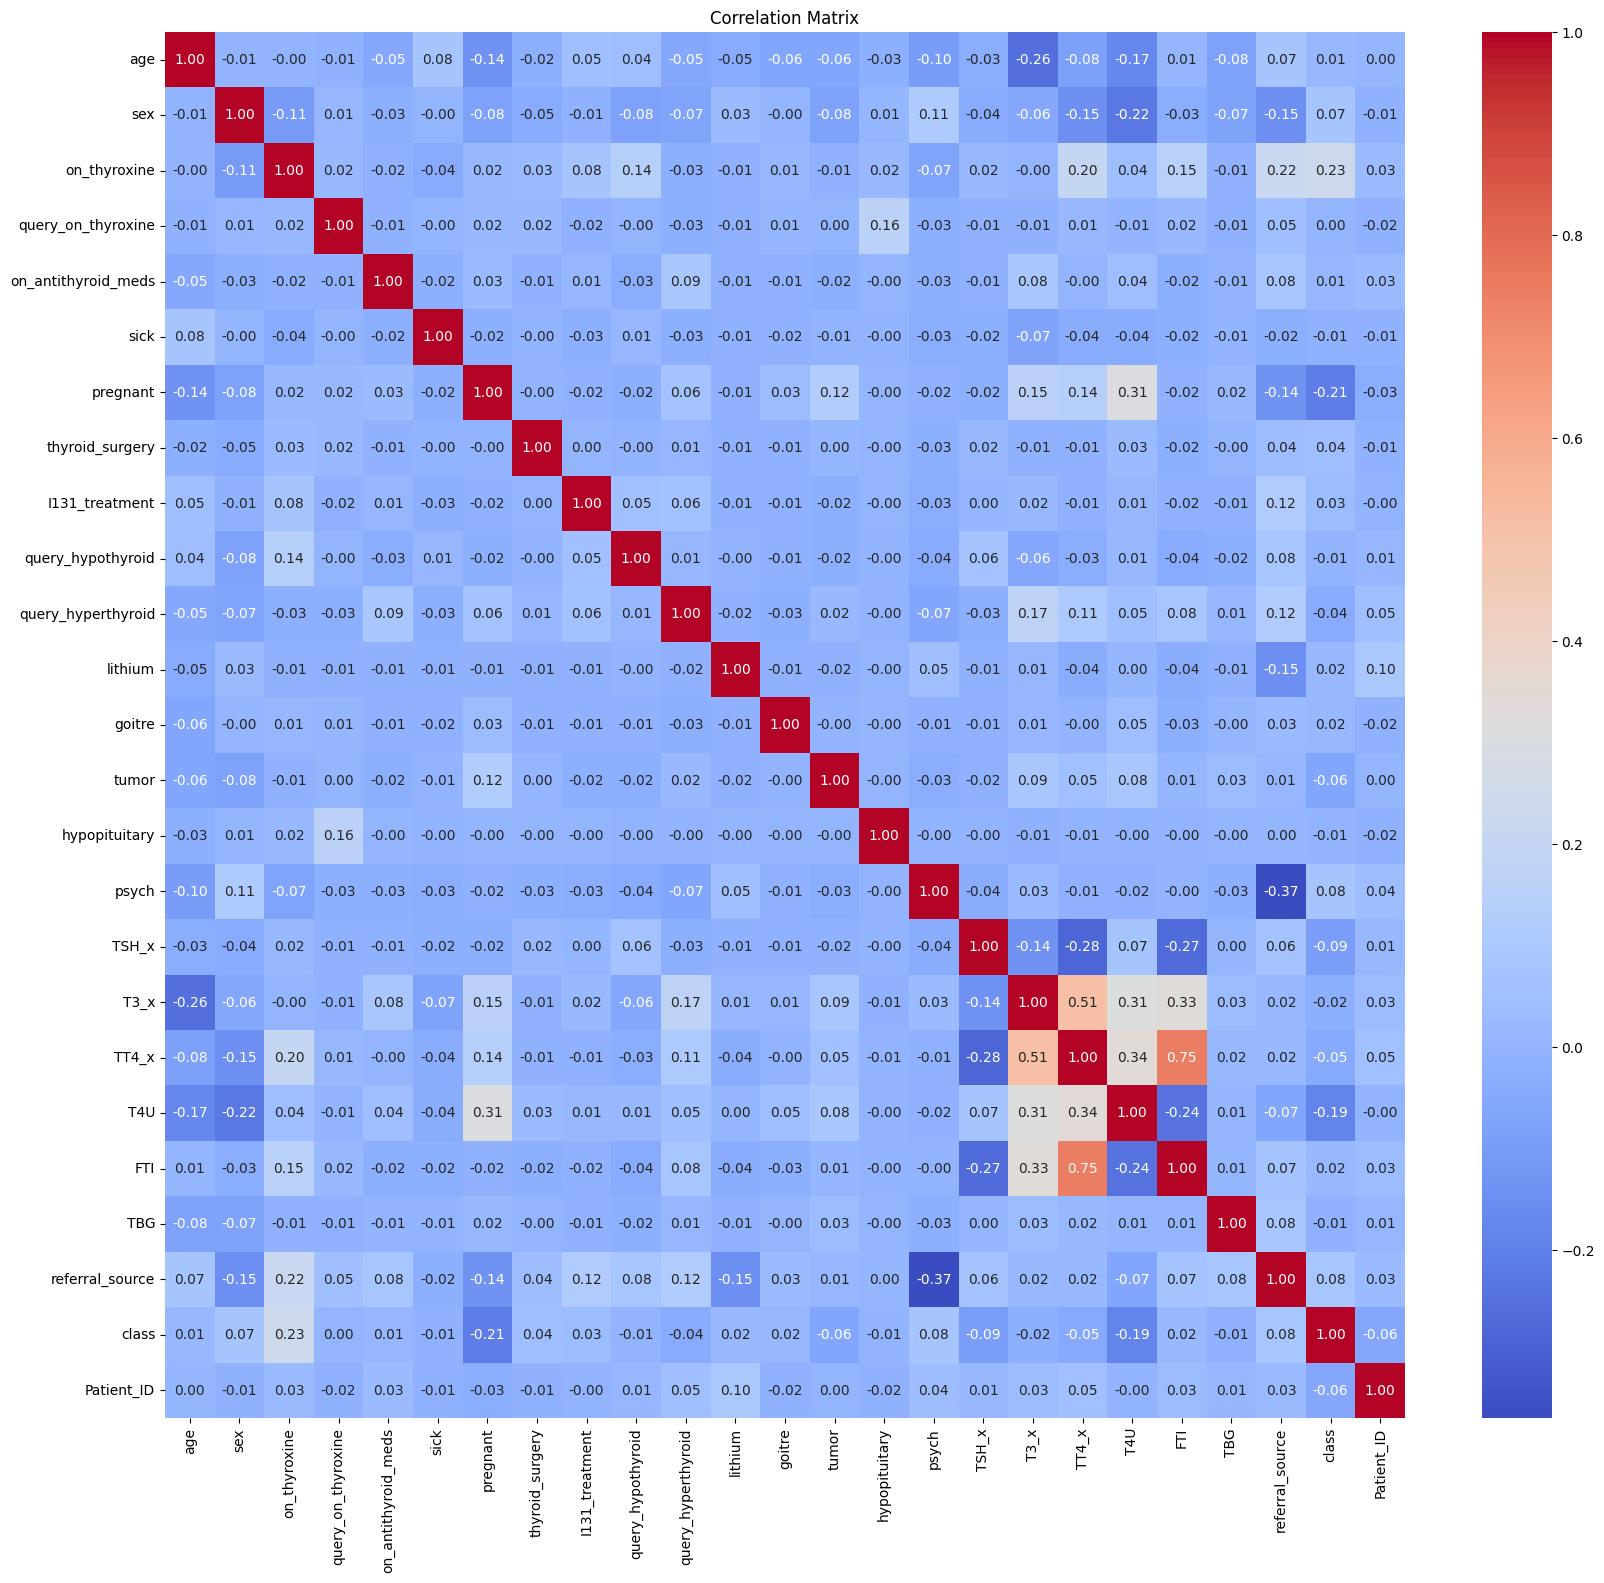

In [50]:
# Step 3: Compute Correlation Matrix
correlation_matrix = corr.corr()

# Visualize Correlation Matrix if needed
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [51]:
# Convert categorical columns to numerical using dummies
data = pd.get_dummies(df_1, columns=['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
                                     'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
                                     'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre',
                                     'tumor', 'hypopituitary', 'psych', 'referral_source'],
                       drop_first=True)
data

,age,TSH_x,T3_x,TT4_x,T4U,FTI,TBG,class,Patient_ID,sex_M,...,lithium_t,goitre_t,tumor_t,hypopituitary_t,psych_t,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_WEST,referral_source_other
0,32,4.948343,2.232518,115.182155,0.984705,113.952402,36.00,Miscellaneous,5,False,...,False,False,False,False,False,False,False,False,False,True
1,63,68.000000,1.853211,48.000000,1.020000,47.000000,2.20,Hypothyroid,19,False,...,False,False,False,False,False,False,False,False,False,True
2,36,1.500000,2.400000,90.000000,1.060000,85.000000,2.20,No Condition,20,False,...,False,False,False,False,False,False,False,False,False,True
3,40,1.200000,2.300000,104.000000,1.080000,96.000000,2.20,No Condition,22,False,...,False,False,False,False,False,False,False,False,False,True
4,40,5.900000,2.100000,88.000000,0.840000,105.000000,2.20,No Condition,23,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,64,0.810000,1.853211,31.000000,0.550000,56.000000,1.85,General Health,9150,True,...,False,False,False,False,False,False,False,True,False,False
6690,60,0.180000,1.853211,28.000000,0.870000,32.000000,1.85,General Health,9154,True,...,False,False,False,False,False,False,False,False,False,True
6691,64,6.925247,1.853211,44.000000,0.530000,83.000000,1.85,Binding Protein,9155,True,...,False,False,False,False,False,False,False,False,False,True
6692,36,4.948343,2.232518,84.000000,1.260000,67.000000,2.20,Binding Protein,9159,False,...,False,False,False,False,False,False,False,False,False,True


# Classification Models

In [52]:
X = data.drop(['class'], axis=1)
y = data['class']

In [53]:
# Splitting the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Shapes of the divided datasets
print(f"Train set shape: {X_train.shape},Test set shape: {X_test.shape}")


Train set shape: (5355, 28),Test set shape: (1339, 28)


In [54]:
from imblearn.combine import SMOTEENN
# SMOTEENN to balance the classes
smoteenn = SMOTEENN(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

In [55]:
trainX = pd.DataFrame(X_train)
trainX['label'] = y_train

testX = pd.DataFrame(X_test)
testX['label'] = y_test

In [56]:
print(f"Train set shape after SMOTEENN: {trainX.shape}, Test set shape: {testX.shape}")

Train set shape after SMOTEENN: (18080, 29), Test set shape: (1339, 29)


### Uploading Train and Test Dataset to S3 Bucket

In [57]:
trainX.to_csv('train-V-1.csv', index=False)
testX.to_csv('test-V-1.csv', index=False)

In [58]:
# send data to S3. SageMaker will take training data from s3
sk_prefix = "sagemaker/thyroid_disease_multi_class_classification/sklearncontainer"

trainpath = sess.upload_data(
    path="train-V-1.csv", bucket=bucket, key_prefix=sk_prefix)

testpath = sess.upload_data(
    path="test-V-1.csv", bucket=bucket, key_prefix=sk_prefix)

print("Training data uploaded to: " + trainpath)
print("Testing data uploaded to: " + testpath)

Training data uploaded to: s3://thyroidsagemakerbucket/sagemaker/thyroid_disease_multi_class_classification/sklearncontainer/train-V-1.csv
Testing data uploaded to: s3://thyroidsagemakerbucket/sagemaker/thyroid_disease_multi_class_classification/sklearncontainer/test-V-1.csv


## SKLEARN Sagemaker

In [59]:
%%writefile script.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO 
import argparse
import joblib
import os
import numpy as np
import pandas as pd
    
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf
    
if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V-1.csv")
    parser.add_argument("--test-file", type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = list(train_df.columns)
    label = features.pop(-1)
    
    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
    
    print("Label column is: ",label)
    print()
    
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (85%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (15%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
    
  
    print("Training RandomForest Model.....")
    print()
    model =  RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state, verbose = 3,n_jobs=-1)
    model.fit(X_train, y_train)
    print()
    

    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print("Model persisted at " + model_path)
    print()

    
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

Overwriting script.py


In [60]:
# Further splitting the train set into train & validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(f"Train set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")


Train set shape: (13560, 28), Validation set shape: (4520, 28), Test set shape: (1339, 28)


In [76]:
%%writefile script.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO 
import argparse
import joblib
import os
import numpy as np
import pandas as pd
    
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf
    
if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V-1.csv")
    parser.add_argument("--test-file", type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = list(train_df.columns)
    label = features.pop(-1)
    
    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
    
    print("Label column is: ",label)
    print()
    
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (85%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (15%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
    
  
    print("Training RandomForest Model.....")
    print()
    model =  RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state, verbose = 3,n_jobs=-1)
    model.fit(X_train, y_train)
    print()
    

    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print("Model persisted at " + model_path)
    print()

    
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

Overwriting script.py


In [79]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role="arn:aws:iam::092382576916:role/Thyroid_Sagemaker",
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="RF-custom-sklearn",
    hyperparameters={
        "n_estimators": 100,
        "random_state": 0,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [80]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)
# sklearn_estimator.fit({"train": datapath}, wait=True)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: RF-custom-sklearn-2025-06-18-17-45-31-175


2025-06-18 17:45:35 Starting - Starting the training job...
2025-06-18 17:45:49 Starting - Preparing the instances for training...
2025-06-18 17:46:13 Downloading - Downloading input data...
2025-06-18 17:46:43 Downloading - Downloading the training image...
2025-06-18 17:47:35 Training - Training image download completed. Training in progress.
2025-06-18 17:47:35 Uploading - Uploading generated training model2025-06-18 17:47:28,870 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-06-18 17:47:28,874 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-18 17:47:28,923 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-06-18 17:47:29,268 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-18 17:47:29,281 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-18 17:47:29,294 sagemaker-training-toolkit INFO

In [81]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2025-06-18 17:47:52 Starting - Preparing the instances for training
2025-06-18 17:47:52 Downloading - Downloading the training image
2025-06-18 17:47:52 Training - Training image download completed. Training in progress.
2025-06-18 17:47:52 Uploading - Uploading generated training model
2025-06-18 17:47:52 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-092382576916/RF-custom-sklearn-2025-06-18-17-45-31-175/output/model.tar.gz


In [82]:
artifact

's3://sagemaker-us-east-1-092382576916/RF-custom-sklearn-2025-06-18-17-45-31-175/output/model.tar.gz'

In [87]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = SKLearnModel(
    name =  model_name,
    model_data=artifact,
    role="arn:aws:iam::092382576916:role/Thyroid_Sagemaker",
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [88]:
model_name

'Custom-sklearn-model-2025-06-18-21-23-46'

In [89]:
##Endpoints deployment
endpoint_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
)

EndpointName=Custom-sklearn-model-2025-06-18-21-23-52


INFO:sagemaker:Creating model with name: Custom-sklearn-model-2025-06-18-21-23-46
INFO:sagemaker:Creating endpoint-config with name Custom-sklearn-model-2025-06-18-21-23-52
INFO:sagemaker:Creating endpoint with name Custom-sklearn-model-2025-06-18-21-23-52


---------!

In [90]:
endpoint_name

'Custom-sklearn-model-2025-06-18-21-23-52'

In [92]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '229c1529-e24c-470e-99eb-851254bb1303',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '229c1529-e24c-470e-99eb-851254bb1303',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 18 Jun 2025 21:31:16 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

### Improved ML Model

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score


In [53]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

In [54]:
from sklearn.metrics import fbeta_score

# Dictionary to store evaluation metrics
evaluation_metrics = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'F2 Score': []
}

# Training and evaluating each classifier
for name, clf in classifiers.items():
    # Training the classifier
    clf.fit(X_train, y_train)

    # Evaluating on the validation set
    y_pred_val = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted')
    precision = precision_score(y_val, y_pred_val, average='weighted')
    recall = recall_score(y_val, y_pred_val, average='weighted')
    # roc_auc = roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr')

    # Calculate F2 score
    f2 = fbeta_score(y_val, y_pred_val, beta=2, average='weighted')

    # Store the evaluation metrics in the dictionary
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['Accuracy'].append(accuracy)
    evaluation_metrics['F1 Score'].append(f1)
    evaluation_metrics['Precision'].append(precision)
    evaluation_metrics['Recall'].append(recall)
    evaluation_metrics['F2 Score'].append(f2)

# DataFrame from the dictionary
metrics_df = pd.DataFrame(evaluation_metrics)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
metrics_df

,Model,Accuracy,F1 Score,Precision,Recall,F2 Score
0,Logistic Regression,0.623894,0.607185,0.598874,0.623894,0.616105
1,Random Forest,0.986062,0.985956,0.986017,0.986062,0.986001
2,Gradient Boosting,0.973451,0.973405,0.973431,0.973451,0.973424
3,AdaBoost,0.761504,0.762071,0.806381,0.761504,0.755664
4,Decision Tree,0.967035,0.966919,0.966875,0.967035,0.966980
5,Gaussian Naive Bayes,0.811062,0.808347,0.829273,0.811062,0.807292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


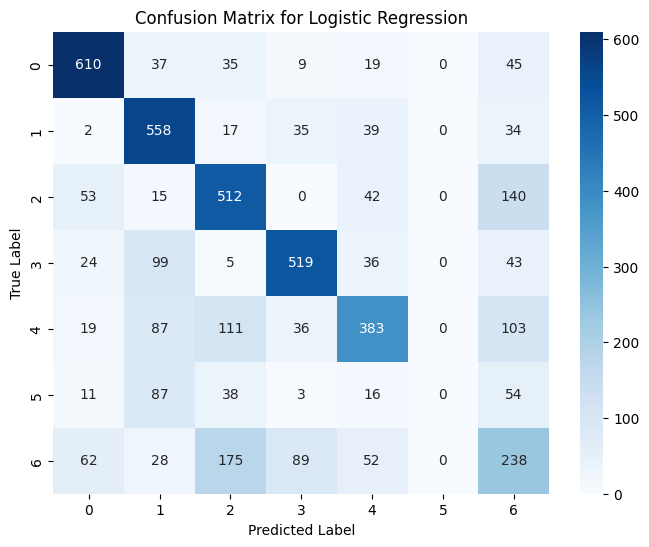

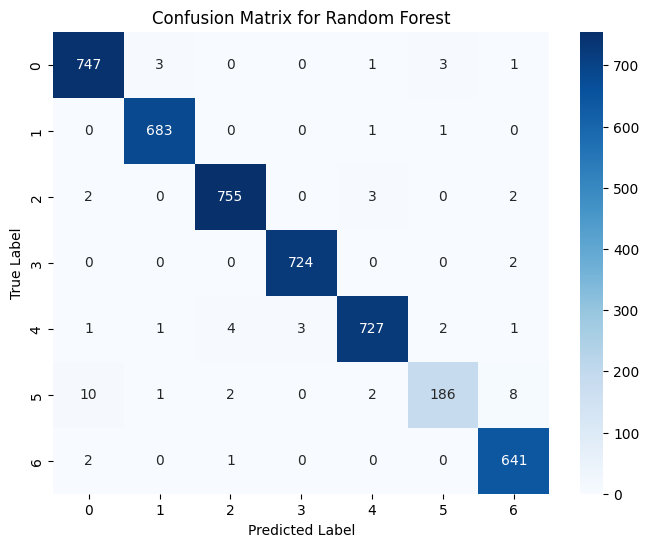

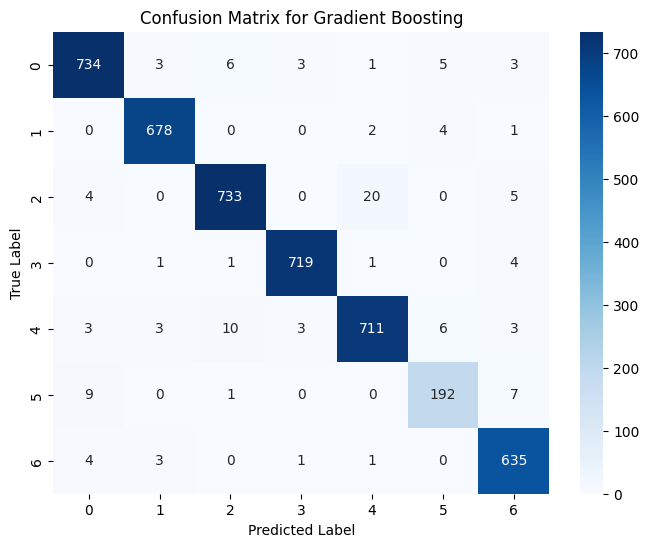

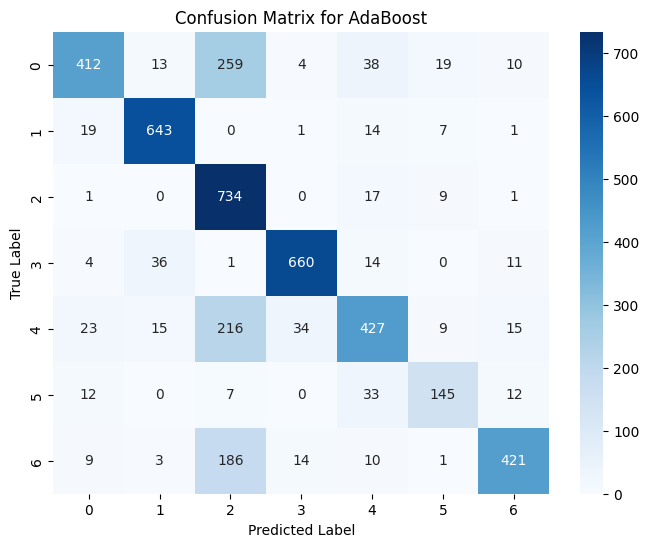

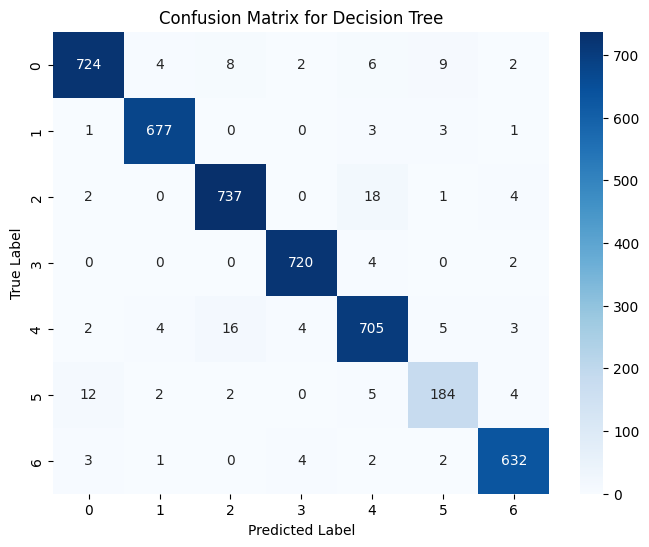

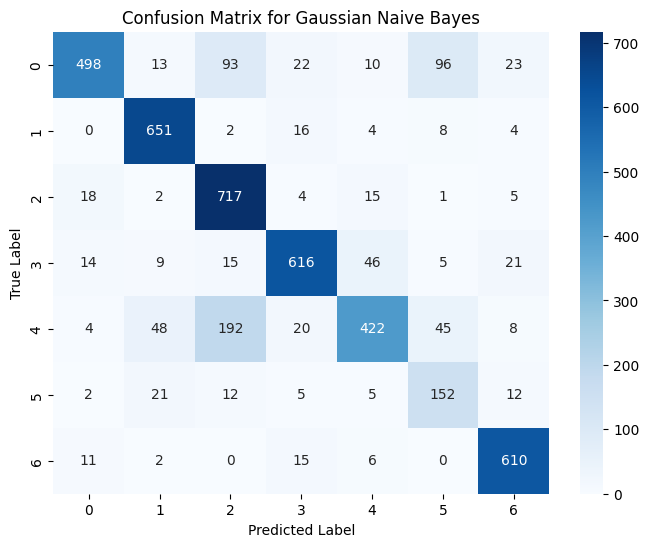

In [56]:
# Iterating through each model
for name, clf in classifiers.items():
    # Training the classifier
    clf.fit(X_train, y_train)

    # Predicting labels on the validation set
    y_pred_val = clf.predict(X_val)

    # Generating confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

**Random Forest** and **Gradient Boosting** models achieved the highest accuracy, F1 score, precision, recall, and ROC AUC, indicating their superior performance compared to other models.

**AdaBoost** model performed poorly across all metrics, indicating that it struggled to classify instances correctly.

**Decision Tree model** also performed well, but slightly lower than Random Forest and Gradient Boosting.

**Gaussian Naive Bayes** achieved moderate performance across all metrics but was outperformed by Random Forest and Gradient Boosting.

In [57]:
#Using Stratified CV to make sure all class are distributed evenly in traing and testing set
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# Initializing dictionary to store evaluation metrics
evaluation_metrics = {'Model': [], 'CV F1 Score': [], 'Validation F1 Score': [],
                      'ROC AUC': [], 'Precision': [], 'Recall': []}

# Cross-validation and evaluating each classifier
for name, clf in classifiers.items():
    # Performing cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')

    # Evaluating on the validation set
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)

    # Calculating evaluation metrics
    cv_f1 = cv_scores.mean()
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    roc_auc = roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr')
    precision = precision_score(y_val, y_pred_val, average='weighted')
    recall = recall_score(y_val, y_pred_val, average='weighted')


    # Appending results to the dictionary
    evaluation_metrics['Model'].append(name)
    evaluation_metrics['CV F1 Score'].append(cv_f1)
    evaluation_metrics['Validation F1 Score'].append(val_f1)
    evaluation_metrics['ROC AUC'].append(roc_auc)
    evaluation_metrics['Precision'].append(precision)
    evaluation_metrics['Recall'].append(recall)

# Creating a DataFrame from the dictionary
CVmetrics_df = pd.DataFrame(evaluation_metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [58]:
CVmetrics_df

,Model,CV F1 Score,Validation F1 Score,ROC AUC,Precision,Recall
0,Logistic Regression,0.556915,0.607185,0.879657,0.598874,0.623894
1,Random Forest,0.983459,0.986632,0.999459,0.986698,0.986726
2,Gradient Boosting,0.971013,0.973866,0.998837,0.973893,0.973894
3,AdaBoost,0.705610,0.762071,0.946063,0.806381,0.761504
4,Decision Tree,0.962614,0.968010,0.976445,0.967969,0.968142
5,Gaussian Naive Bayes,0.801169,0.808347,0.969491,0.829273,0.811062


 The general trends in model performance should be similar between the two evaluations. In the provided results, we can see that Random Forest and Gradient Boosting models still perform the best, followed by Decision Tree and Gaussian Naive Bayes. AdaBoost performs the worst across both evaluations.

 Stratified Cross-Validation (Stratified CV) is a technique used to ensure that each fold of the cross-validation process contains approximately the same proportion of instances from each class as the original dataset. This is particularly useful for classification tasks where the class distribution is imbalanced.Hence moving forward with this technique.

Best Models are Random Forest ,Gradient Boosting and Decision Tree. Lets study them to improve model performance.

In [59]:

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import fbeta_score

import seaborn as sns
import matplotlib.pyplot as plt


In [75]:
# function for plotting confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot average confusion matrices
def plot_avg_confusion_matrix(avg_cm, labels, title):

    fig, ax = plt.subplots(figsize=(10,8))
    im = ax.imshow(avg_cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(avg_cm.shape[1]),
           yticks=np.arange(avg_cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = avg_cm.max() / 2.
    for i in range(avg_cm.shape[0]):
        for j in range(avg_cm.shape[1]):
            ax.text(j, i, format(avg_cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if avg_cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.figure(figsize=(14, 12))
    plt.show()



Random State: 10
Train set shape: (5355, 28), Test set shape: (1339, 28)
Accuracy for Random Forest Classifier: 0.9387602688573562
Accuracy for Gradient Boosting Classifier: 0.9424943988050785
Accuracy for Decision Tree Classifier: 0.936519790888723

Random Forest Classifier:
Confusion Matrix:


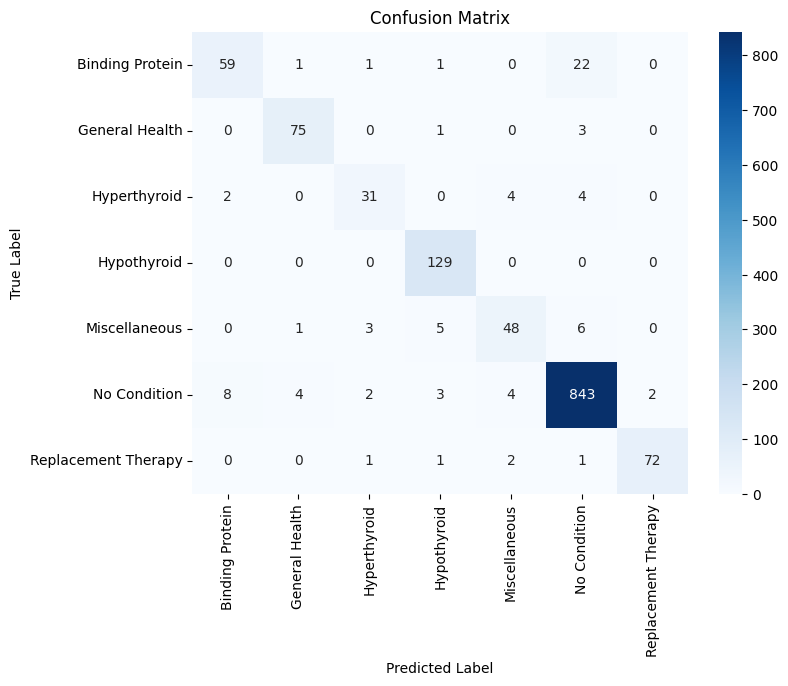

F2 Score for each class:
[0.72839506 0.94458438 0.76732673 0.98323171 0.77419355 0.97052729
 0.94240838]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.86      0.70      0.77        84
     General Health       0.93      0.95      0.94        79
       Hyperthyroid       0.82      0.76      0.78        41
        Hypothyroid       0.92      1.00      0.96       129
      Miscellaneous       0.83      0.76      0.79        63
       No Condition       0.96      0.97      0.97       866
Replacement Therapy       0.97      0.94      0.95        77

           accuracy                           0.94      1339
          macro avg       0.90      0.87      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.93801344 0.94921583 0.94025392 0.92979836 0.68908819]

Gradient Boosting Classifier:
Confusion Matrix:


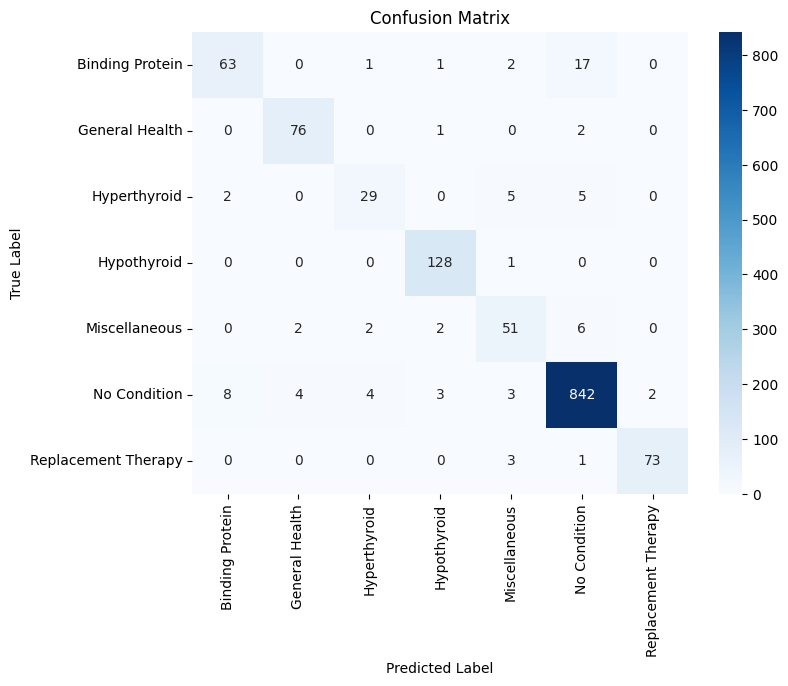

F2 Score for each class:
[0.77017115 0.95477387 0.725      0.98310292 0.8044164  0.97071709
 0.95300261]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.86      0.75      0.80        84
     General Health       0.93      0.96      0.94        79
       Hyperthyroid       0.81      0.71      0.75        41
        Hypothyroid       0.95      0.99      0.97       129
      Miscellaneous       0.78      0.81      0.80        63
       No Condition       0.96      0.97      0.97       866
Replacement Therapy       0.97      0.95      0.96        77

           accuracy                           0.94      1339
          macro avg       0.90      0.88      0.89      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92905153 0.94473488 0.93129201 0.90739358 0.8490284 ]

Decision Tree Classifier:
Confusion Matrix:


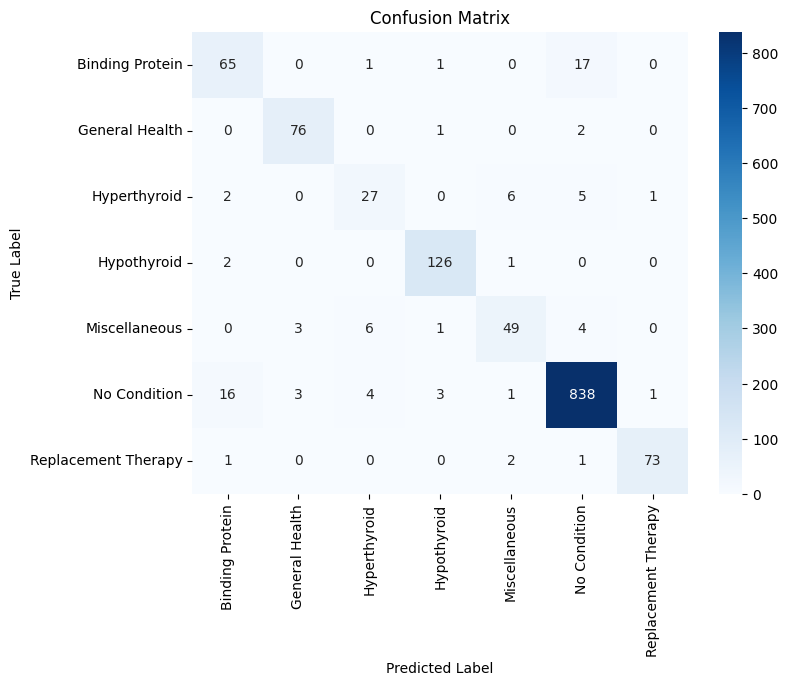

F2 Score for each class:
[0.77014218 0.95477387 0.66831683 0.97222222 0.78778135 0.96744401
 0.95300261]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.76      0.77      0.76        84
     General Health       0.93      0.96      0.94        79
       Hyperthyroid       0.71      0.66      0.68        41
        Hypothyroid       0.95      0.98      0.97       129
      Miscellaneous       0.83      0.78      0.80        63
       No Condition       0.97      0.97      0.97       866
Replacement Therapy       0.97      0.95      0.96        77

           accuracy                           0.94      1339
          macro avg       0.87      0.87      0.87      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92008962 0.94398805 0.92905153 0.90067214 0.35724963]


Random State: 20
Train set shape: (5355, 28), Test set shape: (1339, 28)
Accuracy for Random Forest Classifier: 0.

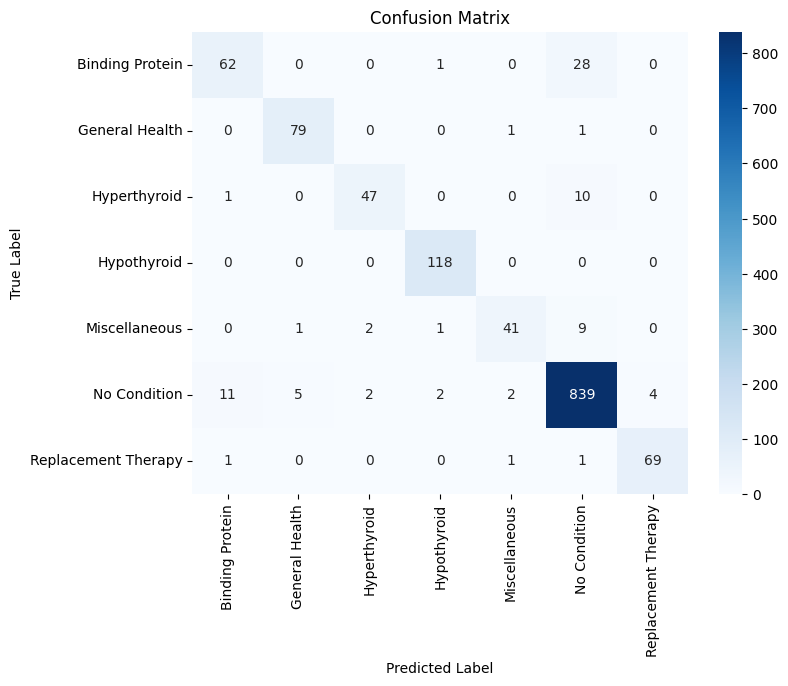

F2 Score for each class:
[0.70615034 0.96577017 0.83038869 0.99326599 0.78544061 0.96481141
 0.95567867]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.83      0.68      0.75        91
     General Health       0.93      0.98      0.95        81
       Hyperthyroid       0.92      0.81      0.86        58
        Hypothyroid       0.97      1.00      0.98       118
      Miscellaneous       0.91      0.76      0.83        54
       No Condition       0.94      0.97      0.96       865
Replacement Therapy       0.95      0.96      0.95        72

           accuracy                           0.94      1339
          macro avg       0.92      0.88      0.90      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.93278566 0.9454817  0.94100075 0.92606423 0.67787743]

Gradient Boosting Classifier:
Confusion Matrix:


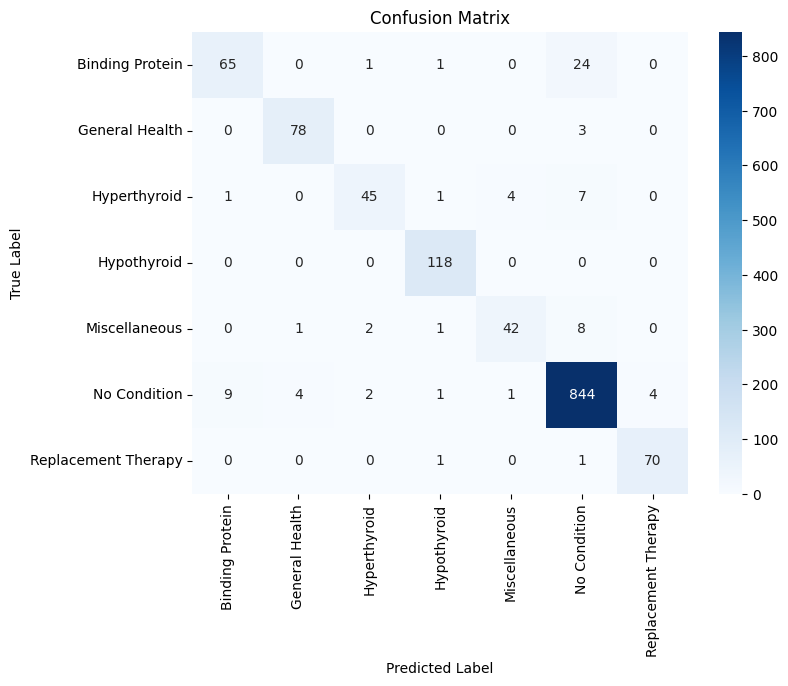

F2 Score for each class:
[0.74031891 0.95823096 0.79787234 0.99159664 0.79847909 0.97078445
 0.96685083]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.87      0.71      0.78        91
     General Health       0.94      0.96      0.95        81
       Hyperthyroid       0.90      0.78      0.83        58
        Hypothyroid       0.96      1.00      0.98       118
      Miscellaneous       0.89      0.78      0.83        54
       No Condition       0.95      0.98      0.96       865
Replacement Therapy       0.95      0.97      0.96        72

           accuracy                           0.94      1339
          macro avg       0.92      0.88      0.90      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.93129201 0.94473488 0.93203883 0.91262136 0.8490284 ]

Decision Tree Classifier:
Confusion Matrix:


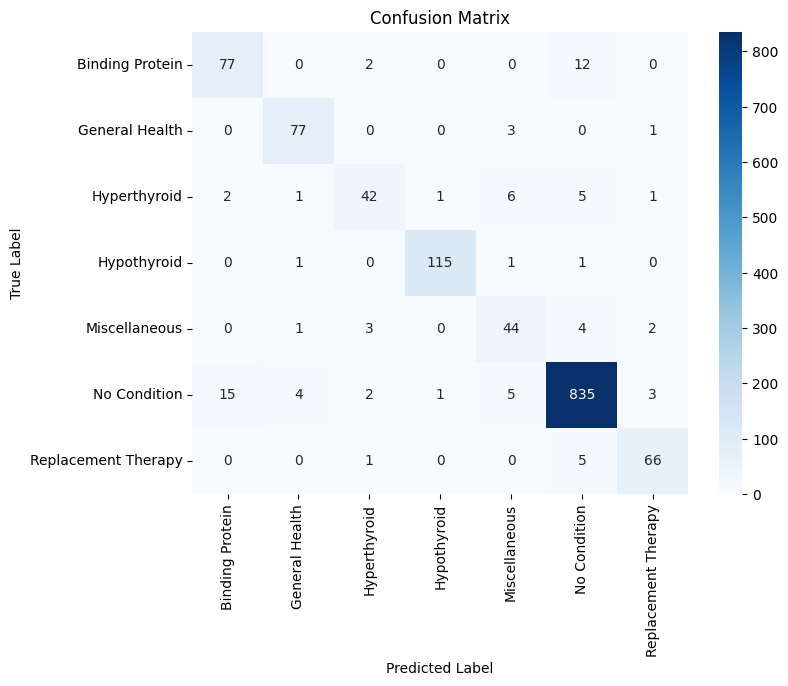

F2 Score for each class:
[0.84061135 0.94362745 0.74468085 0.9762309  0.8        0.96598797
 0.91412742]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.82      0.85      0.83        91
     General Health       0.92      0.95      0.93        81
       Hyperthyroid       0.84      0.72      0.78        58
        Hypothyroid       0.98      0.97      0.98       118
      Miscellaneous       0.75      0.81      0.78        54
       No Condition       0.97      0.97      0.97       865
Replacement Therapy       0.90      0.92      0.91        72

           accuracy                           0.94      1339
          macro avg       0.88      0.88      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.8304705  0.94324122 0.92905153 0.91262136 0.35949178]


Random State: 30
Train set shape: (5355, 28), Test set shape: (1339, 28)
Accuracy for Random Forest Classifier: 0.

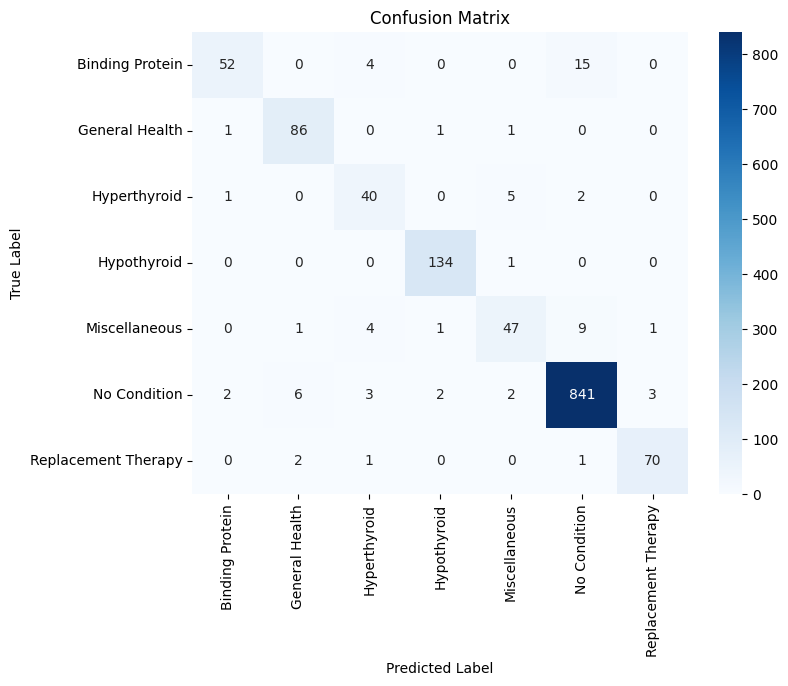

F2 Score for each class:
[0.76470588 0.95343681 0.81967213 0.98820059 0.76298701 0.97699814
 0.94594595]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.93      0.73      0.82        71
     General Health       0.91      0.97      0.93        89
       Hyperthyroid       0.77      0.83      0.80        48
        Hypothyroid       0.97      0.99      0.98       135
      Miscellaneous       0.84      0.75      0.79        63
       No Condition       0.97      0.98      0.97       859
Replacement Therapy       0.95      0.95      0.95        74

           accuracy                           0.95      1339
          macro avg       0.90      0.89      0.89      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93054518 0.94846901 0.93801344 0.92606423 0.59790732]

Gradient Boosting Classifier:
Confusion Matrix:


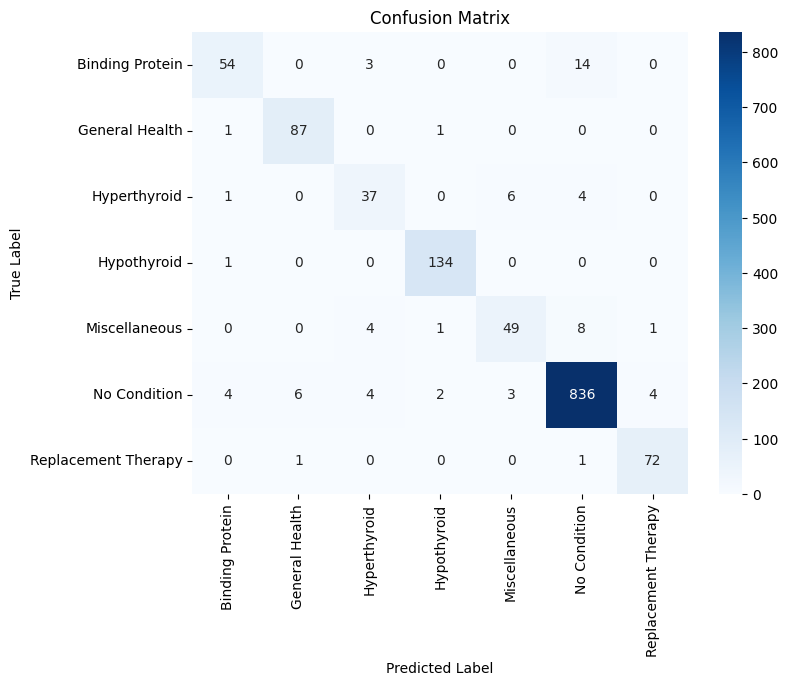

F2 Score for each class:
[0.7826087  0.96666667 0.77083333 0.98820059 0.79032258 0.97231914
 0.96514745]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.89      0.76      0.82        71
     General Health       0.93      0.98      0.95        89
       Hyperthyroid       0.77      0.77      0.77        48
        Hypothyroid       0.97      0.99      0.98       135
      Miscellaneous       0.84      0.78      0.81        63
       No Condition       0.97      0.97      0.97       859
Replacement Therapy       0.94      0.97      0.95        74

           accuracy                           0.95      1339
          macro avg       0.90      0.89      0.89      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93129201 0.94473488 0.93129201 0.90888723 0.85052317]

Decision Tree Classifier:
Confusion Matrix:


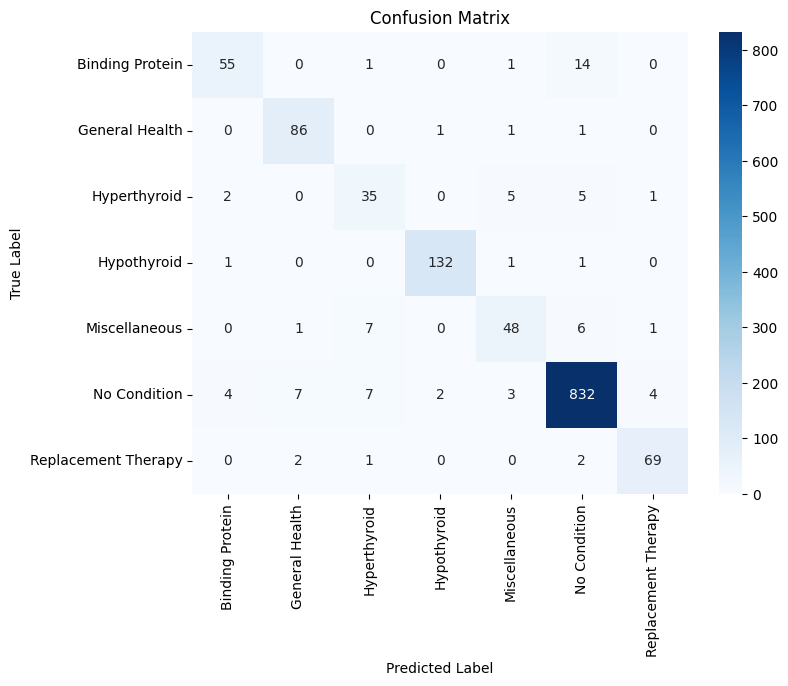

F2 Score for each class:
[0.79479769 0.95132743 0.72016461 0.97777778 0.77170418 0.96811729
 0.92991914]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.89      0.77      0.83        71
     General Health       0.90      0.97      0.93        89
       Hyperthyroid       0.69      0.73      0.71        48
        Hypothyroid       0.98      0.98      0.98       135
      Miscellaneous       0.81      0.76      0.79        63
       No Condition       0.97      0.97      0.97       859
Replacement Therapy       0.92      0.93      0.93        74

           accuracy                           0.94      1339
          macro avg       0.88      0.87      0.87      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.83644511 0.9424944  0.92755788 0.91112771 0.35650224]


Random State: 40
Train set shape: (5355, 28), Test set shape: (1339, 28)
Accuracy for Random Forest Classifier: 0.

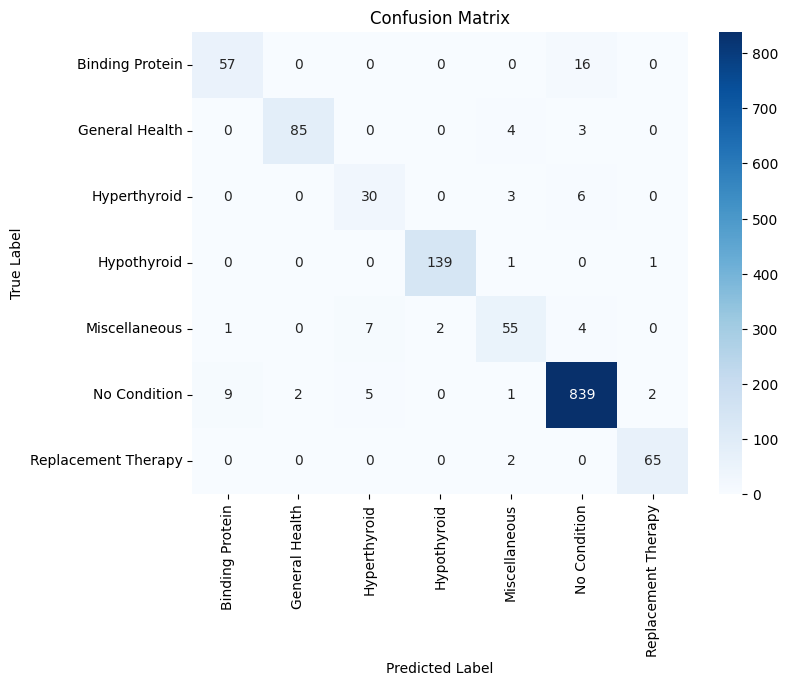

F2 Score for each class:
[0.79387187 0.93406593 0.75757576 0.9858156  0.80409357 0.9755814
 0.9672619 ]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.85      0.78      0.81        73
     General Health       0.98      0.92      0.95        92
       Hyperthyroid       0.71      0.77      0.74        39
        Hypothyroid       0.99      0.99      0.99       141
      Miscellaneous       0.83      0.80      0.81        69
       No Condition       0.97      0.98      0.97       858
Replacement Therapy       0.96      0.97      0.96        67

           accuracy                           0.95      1339
          macro avg       0.90      0.89      0.89      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93427931 0.95145631 0.93950709 0.92307692 0.62032885]

Gradient Boosting Classifier:
Confusion Matrix:


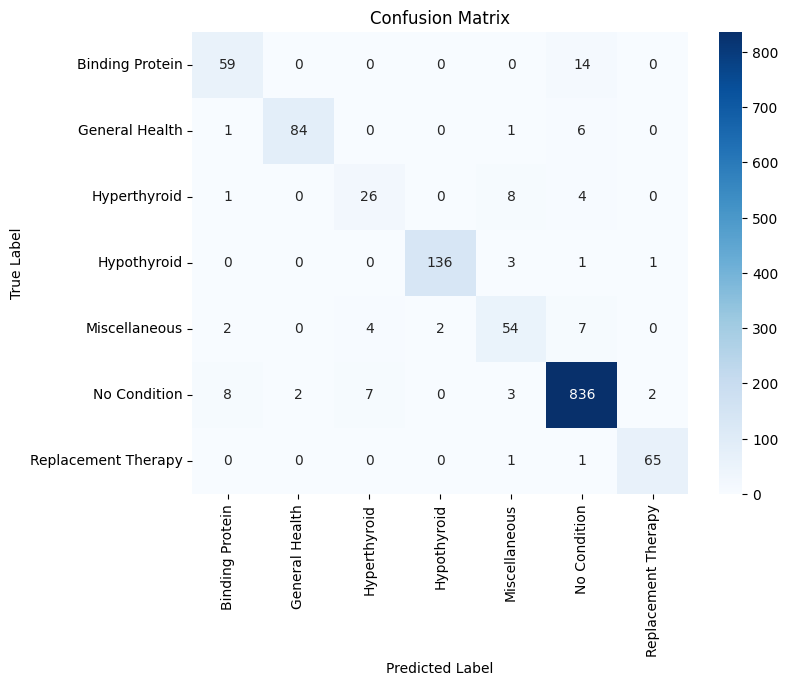

F2 Score for each class:
[0.81267218 0.92511013 0.67357513 0.96866097 0.78034682 0.97186701
 0.9672619 ]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.83      0.81      0.82        73
     General Health       0.98      0.91      0.94        92
       Hyperthyroid       0.70      0.67      0.68        39
        Hypothyroid       0.99      0.96      0.97       141
      Miscellaneous       0.77      0.78      0.78        69
       No Condition       0.96      0.97      0.97       858
Replacement Therapy       0.96      0.97      0.96        67

           accuracy                           0.94      1339
          macro avg       0.88      0.87      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92979836 0.94473488 0.93129201 0.91187453 0.85276532]

Decision Tree Classifier:
Confusion Matrix:


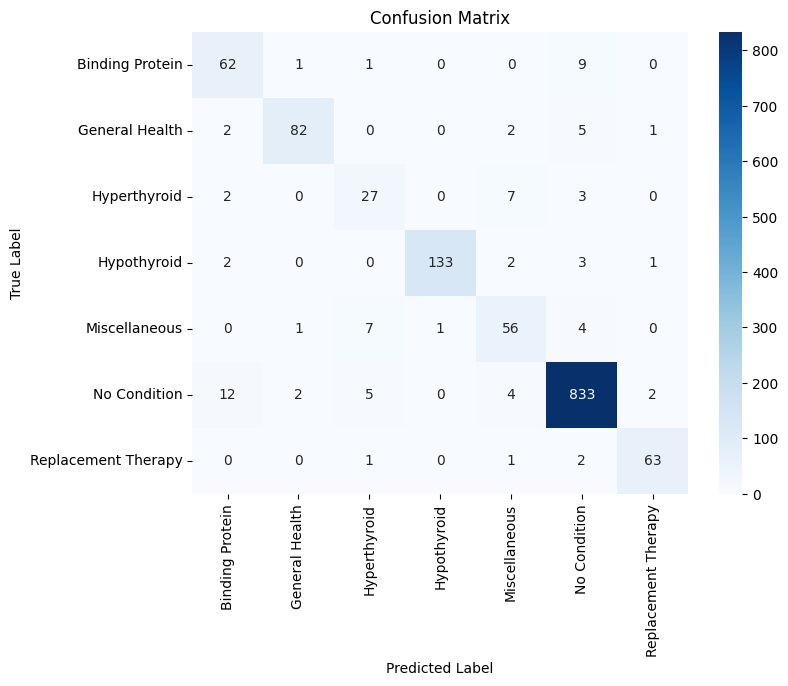

F2 Score for each class:
[0.83333333 0.9030837  0.68527919 0.95272206 0.8045977  0.97063622
 0.94029851]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.78      0.85      0.81        73
     General Health       0.95      0.89      0.92        92
       Hyperthyroid       0.66      0.69      0.68        39
        Hypothyroid       0.99      0.94      0.97       141
      Miscellaneous       0.78      0.81      0.79        69
       No Condition       0.97      0.97      0.97       858
Replacement Therapy       0.94      0.94      0.94        67

           accuracy                           0.94      1339
          macro avg       0.87      0.87      0.87      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.83719193 0.9454817  0.92830471 0.91112771 0.35650224]


Random State: 50
Train set shape: (5355, 28), Test set shape: (1339, 28)
Accuracy for Random Forest Classifier: 0.

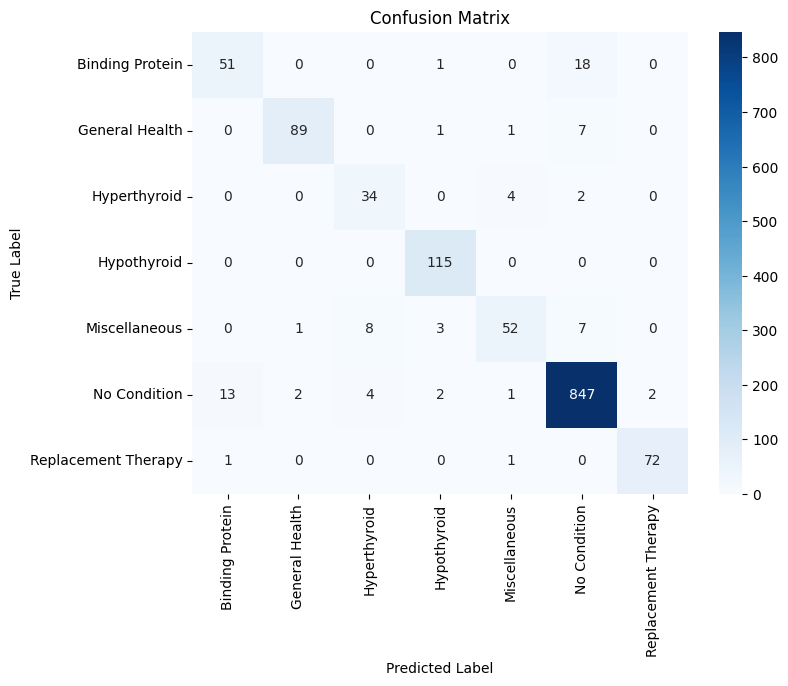

F2 Score for each class:
[0.73913043 0.91942149 0.82524272 0.98797251 0.75801749 0.97021764
 0.97297297]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.78      0.73      0.76        70
     General Health       0.97      0.91      0.94        98
       Hyperthyroid       0.74      0.85      0.79        40
        Hypothyroid       0.94      1.00      0.97       115
      Miscellaneous       0.88      0.73      0.80        71
       No Condition       0.96      0.97      0.97       871
Replacement Therapy       0.97      0.97      0.97        74

           accuracy                           0.94      1339
          macro avg       0.89      0.88      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.93054518 0.94772218 0.93577296 0.9253174  0.70926756]

Gradient Boosting Classifier:
Confusion Matrix:


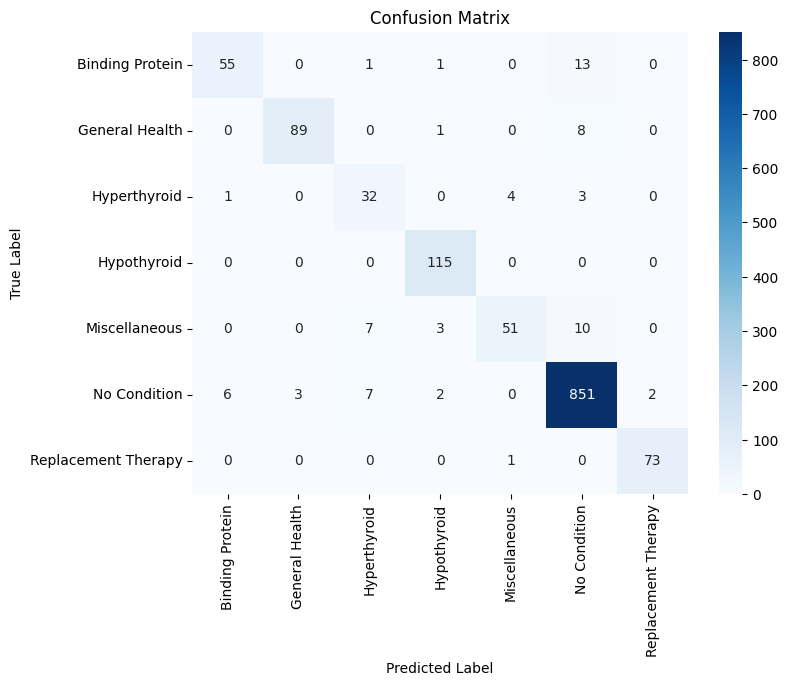

F2 Score for each class:
[0.80409357 0.91942149 0.77294686 0.98797251 0.75       0.97390707
 0.98382749]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.89      0.79      0.83        70
     General Health       0.97      0.91      0.94        98
       Hyperthyroid       0.68      0.80      0.74        40
        Hypothyroid       0.94      1.00      0.97       115
      Miscellaneous       0.91      0.72      0.80        71
       No Condition       0.96      0.98      0.97       871
Replacement Therapy       0.97      0.99      0.98        74

           accuracy                           0.95      1339
          macro avg       0.90      0.88      0.89      1339
       weighted avg       0.95      0.95      0.94      1339

Cross-validation Scores:
[0.92979836 0.94473488 0.93203883 0.91262136 0.85201794]

Decision Tree Classifier:
Confusion Matrix:


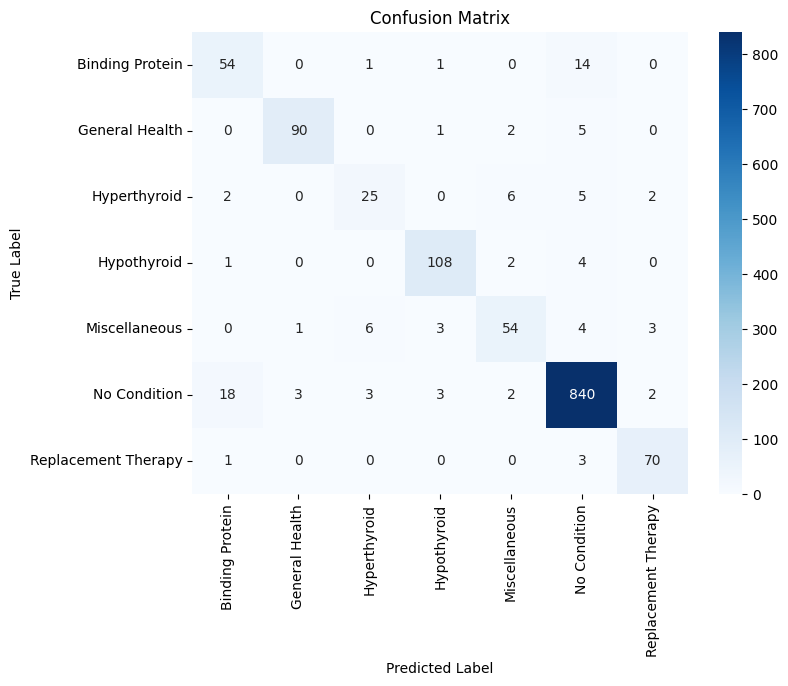

F2 Score for each class:
[0.75842697 0.92592593 0.64102564 0.9375     0.77142857 0.96352374
 0.9383378 ]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.71      0.77      0.74        70
     General Health       0.96      0.92      0.94        98
       Hyperthyroid       0.71      0.62      0.67        40
        Hypothyroid       0.93      0.94      0.94       115
      Miscellaneous       0.82      0.76      0.79        71
       No Condition       0.96      0.96      0.96       871
Replacement Therapy       0.91      0.95      0.93        74

           accuracy                           0.93      1339
          macro avg       0.86      0.85      0.85      1339
       weighted avg       0.93      0.93      0.93      1339

Cross-validation Scores:
[0.83495146 0.94324122 0.92979836 0.90141897 0.35575486]




In [61]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

random_states = [10, 20, 30, 40, 50]
skf = StratifiedKFold(n_splits=5)

for state in random_states:
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    # Shapes of datasets
    print(f"Random State: {state}")
    print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Initializing and training selected models, and evaluating their performance on the test set

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Accuracy for Random Forest Classifier: {accuracy_rf}")

    clf_gb = GradientBoostingClassifier()
    clf_gb.fit(X_train, y_train)
    y_pred_gb = clf_gb.predict(X_test)
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    print(f"Accuracy for Gradient Boosting Classifier: {accuracy_gb}")

    clf_dt = DecisionTreeClassifier()
    clf_dt.fit(X_train, y_train)
    y_pred_dt = clf_dt.predict(X_test)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Accuracy for Decision Tree Classifier: {accuracy_dt}")

    # Generating confusion matrix and calculate F1 and F2 scores for each class
    labels = np.unique(y_test)
    cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
    cm_gb = confusion_matrix(y_test, y_pred_gb, labels=labels)
    cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)



    f2_rf = fbeta_score(y_test, y_pred_rf, beta=2, average=None)
    f2_gb = fbeta_score(y_test, y_pred_gb, beta=2, average=None)
    f2_dt = fbeta_score(y_test, y_pred_dt, beta=2, average=None)

    print("\nRandom Forest Classifier:")
    print("Confusion Matrix:")
    plot_confusion_matrix(cm_rf, labels=np.unique(y))

    print("F2 Score for each class:")
    print(f2_rf)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_rf))
    print("Cross-validation Scores:")
    cv_scores_rf = cross_val_score(clf_rf, X, y, cv=skf)
    print(cv_scores_rf)

    print("\nGradient Boosting Classifier:")
    print("Confusion Matrix:")
    plot_confusion_matrix(cm_gb, labels=np.unique(y))
    print("F2 Score for each class:")
    print(f2_gb)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_gb))
    print("Cross-validation Scores:")
    cv_scores_gb = cross_val_score(clf_gb, X, y, cv=skf)
    print(cv_scores_gb)

    print("\nDecision Tree Classifier:")
    print("Confusion Matrix:")

    plot_confusion_matrix(cm_dt, labels=np.unique(y))
    print("F2 Score for each class:")
    print(f2_dt)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_dt))
    print("Cross-validation Scores:")
    cv_scores_dt = cross_val_score(clf_dt, X, y, cv=skf)
    print(cv_scores_dt)
    print("\n")

Random State: 10
Train set shape: (5355, 28), Test set shape: (1339, 28)
Best params for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Accuracy for Random Forest Classifier: 0.9357729648991785
Best params for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Accuracy for Gradient Boosting Classifier: 0.9507094846900672
Best params for Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini'}
Accuracy for Decision Tree Classifier: 0.9275578790141897

Random Forest Classifier:
Confusion Matrix:


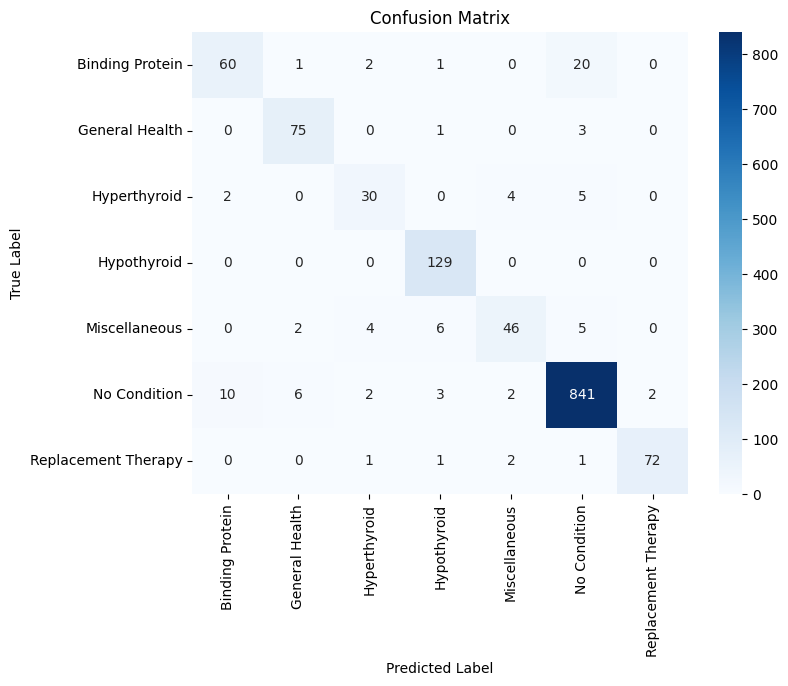

F2 Score for each class:
[0.73529412 0.9375     0.73891626 0.98173516 0.75163399 0.96911731
 0.94240838]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.83      0.71      0.77        84
     General Health       0.89      0.95      0.92        79
       Hyperthyroid       0.77      0.73      0.75        41
        Hypothyroid       0.91      1.00      0.96       129
      Miscellaneous       0.85      0.73      0.79        63
       No Condition       0.96      0.97      0.97       866
Replacement Therapy       0.97      0.94      0.95        77

           accuracy                           0.94      1339
          macro avg       0.89      0.86      0.87      1339
       weighted avg       0.93      0.94      0.93      1339

Cross-validation Scores:
[0.93129201 0.94996266 0.93651979 0.92307692 0.70254111]

Gradient Boosting Classifier:
Confusion Matrix:


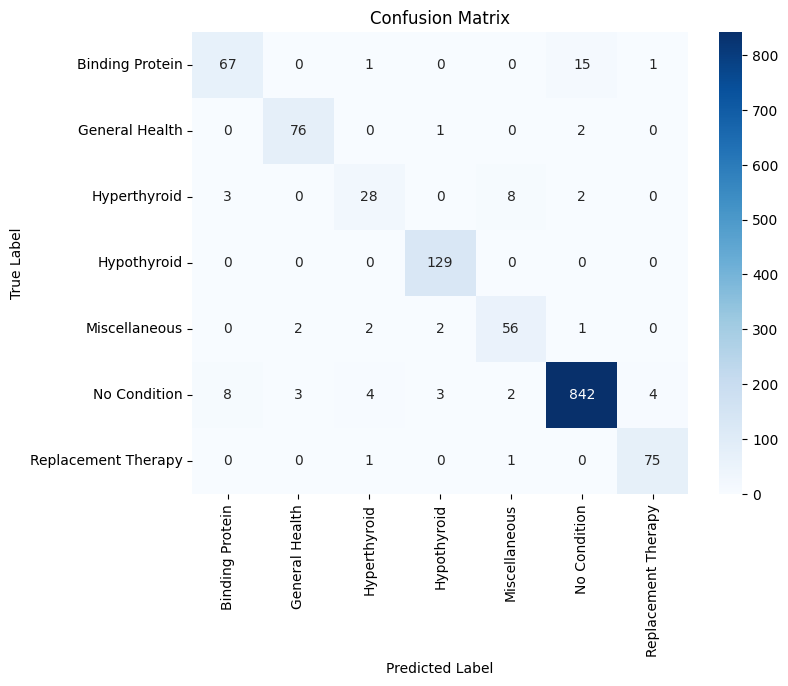

F2 Score for each class:
[0.80917874 0.95717884 0.7        0.99078341 0.87774295 0.97318539
 0.96649485]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.86      0.80      0.83        84
     General Health       0.94      0.96      0.95        79
       Hyperthyroid       0.78      0.68      0.73        41
        Hypothyroid       0.96      1.00      0.98       129
      Miscellaneous       0.84      0.89      0.86        63
       No Condition       0.98      0.97      0.97       866
Replacement Therapy       0.94      0.97      0.96        77

           accuracy                           0.95      1339
          macro avg       0.90      0.90      0.90      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93203883 0.94846901 0.94772218 0.94100075 0.89088191]

Decision Tree Classifier:
Confusion Matrix:


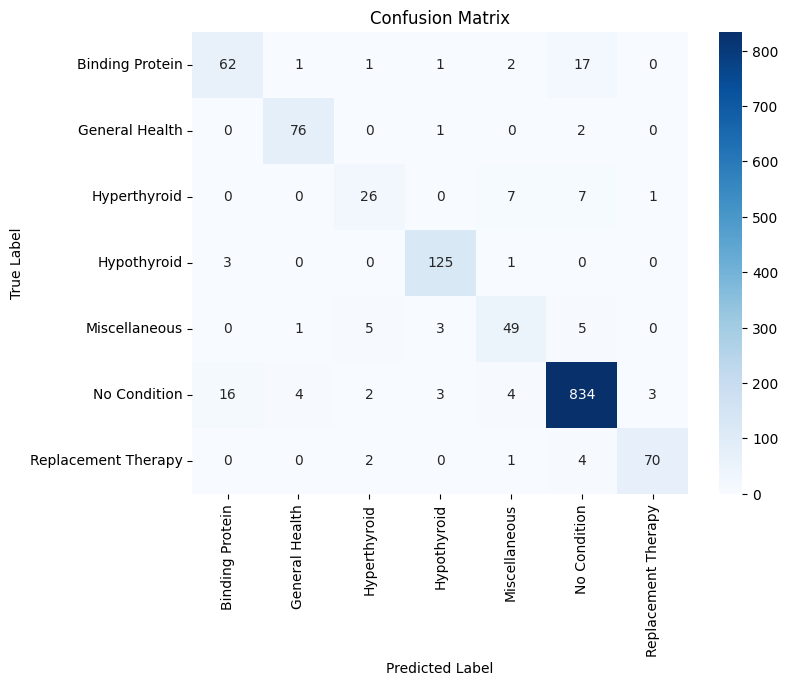

F2 Score for each class:
[0.74340528 0.95477387 0.65       0.96302003 0.77531646 0.96238172
 0.91623037]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.77      0.74      0.75        84
     General Health       0.93      0.96      0.94        79
       Hyperthyroid       0.72      0.63      0.68        41
        Hypothyroid       0.94      0.97      0.95       129
      Miscellaneous       0.77      0.78      0.77        63
       No Condition       0.96      0.96      0.96       866
Replacement Therapy       0.95      0.91      0.93        77

           accuracy                           0.93      1339
          macro avg       0.86      0.85      0.86      1339
       weighted avg       0.93      0.93      0.93      1339

Cross-validation Scores:
[0.93801344 0.9454817  0.92979836 0.90067214 0.89536622]


Random State: 20
Train set shape: (5355, 28), Test set shape: (1339, 28)
Best params for Random Forest: {'n_estima

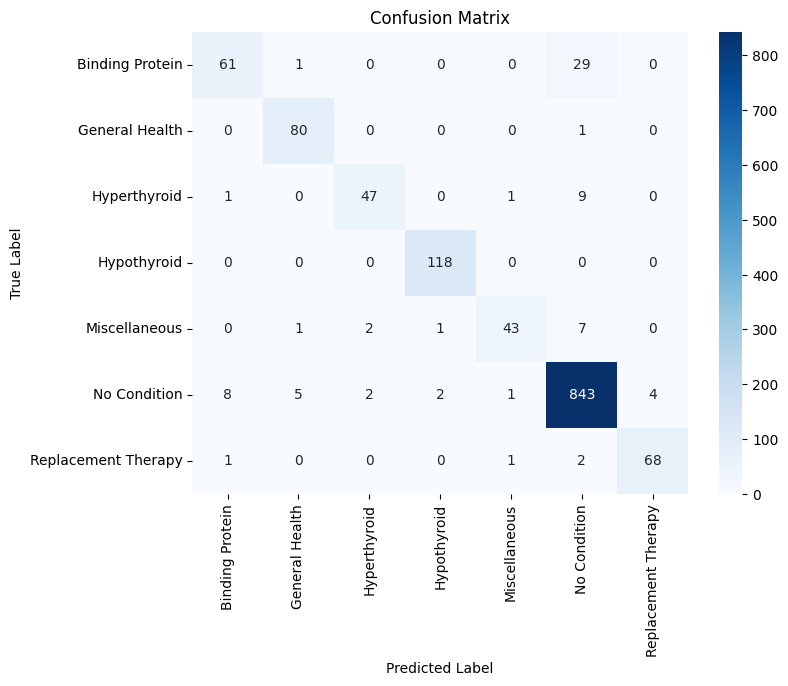

F2 Score for each class:
[0.70114943 0.97323601 0.83038869 0.99494098 0.82061069 0.96874282
 0.94444444]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.86      0.67      0.75        91
     General Health       0.92      0.99      0.95        81
       Hyperthyroid       0.92      0.81      0.86        58
        Hypothyroid       0.98      1.00      0.99       118
      Miscellaneous       0.93      0.80      0.86        54
       No Condition       0.95      0.97      0.96       865
Replacement Therapy       0.94      0.94      0.94        72

           accuracy                           0.94      1339
          macro avg       0.93      0.88      0.90      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.93203883 0.95294996 0.94473488 0.92307692 0.56950673]

Gradient Boosting Classifier:
Confusion Matrix:


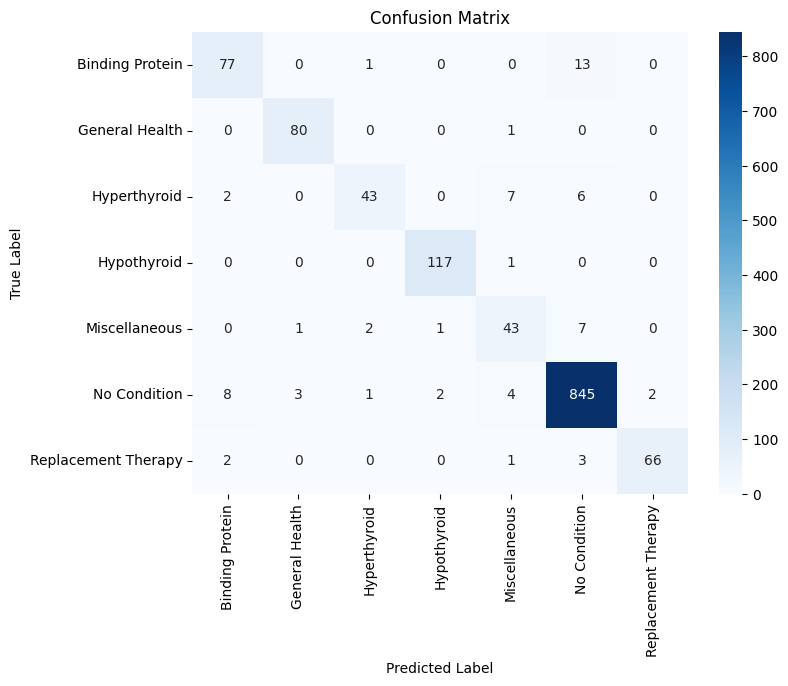

F2 Score for each class:
[0.84988962 0.98039216 0.77060932 0.98817568 0.78754579 0.97485002
 0.92696629]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.87      0.85      0.86        91
     General Health       0.95      0.99      0.97        81
       Hyperthyroid       0.91      0.74      0.82        58
        Hypothyroid       0.97      0.99      0.98       118
      Miscellaneous       0.75      0.80      0.77        54
       No Condition       0.97      0.98      0.97       865
Replacement Therapy       0.97      0.92      0.94        72

           accuracy                           0.95      1339
          macro avg       0.91      0.89      0.90      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93203883 0.94921583 0.94473488 0.94025392 0.88863976]

Decision Tree Classifier:
Confusion Matrix:


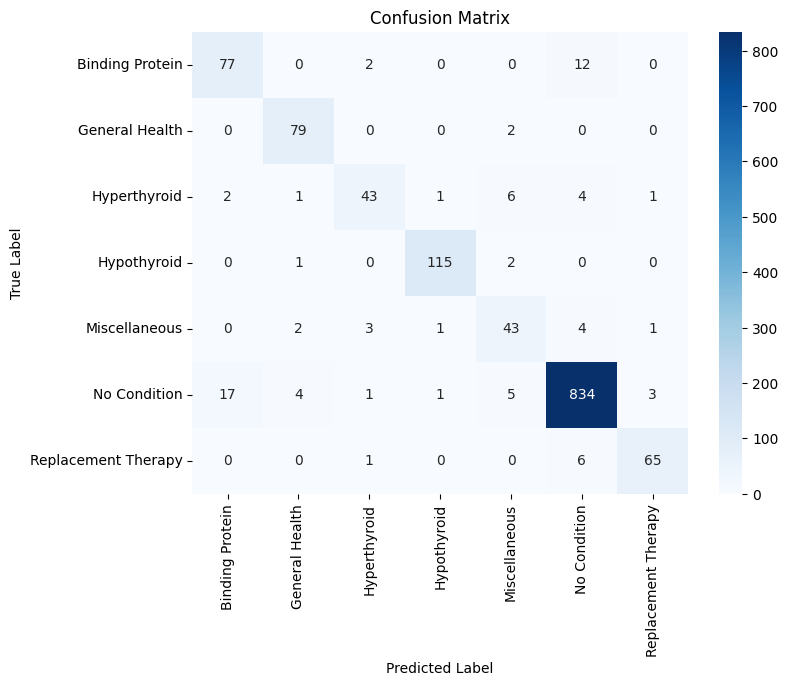

F2 Score for each class:
[0.83695652 0.96107056 0.76241135 0.97457627 0.78467153 0.96527778
 0.90782123]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.80      0.85      0.82        91
     General Health       0.91      0.98      0.94        81
       Hyperthyroid       0.86      0.74      0.80        58
        Hypothyroid       0.97      0.97      0.97       118
      Miscellaneous       0.74      0.80      0.77        54
       No Condition       0.97      0.96      0.97       865
Replacement Therapy       0.93      0.90      0.92        72

           accuracy                           0.94      1339
          macro avg       0.88      0.89      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92158327 0.94100075 0.92905153 0.90067214 0.35799701]


Random State: 30
Train set shape: (5355, 28), Test set shape: (1339, 28)
Best params for Random Forest: {'n_estima

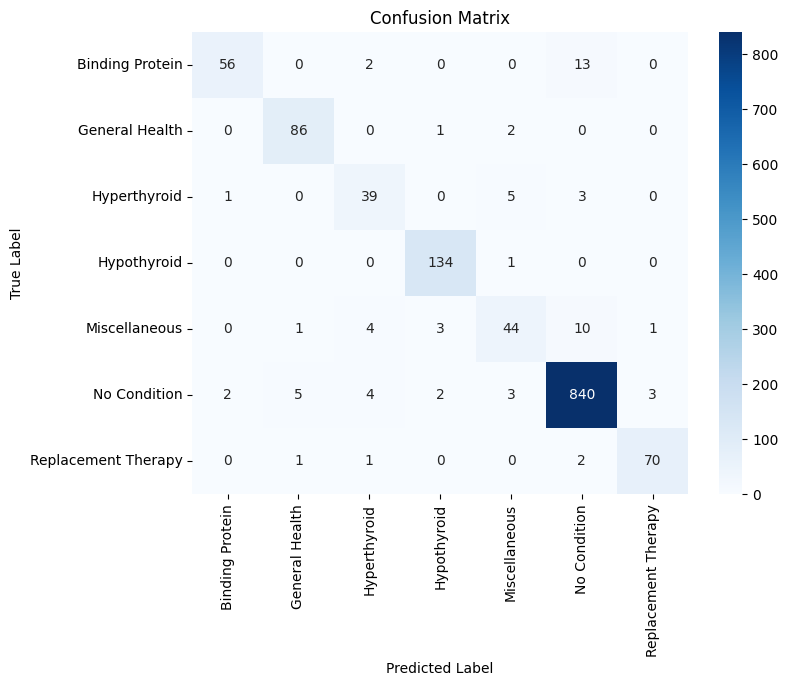

F2 Score for each class:
[0.81632653 0.95768374 0.80578512 0.98529412 0.71661238 0.97583643
 0.94594595]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.95      0.79      0.86        71
     General Health       0.92      0.97      0.95        89
       Hyperthyroid       0.78      0.81      0.80        48
        Hypothyroid       0.96      0.99      0.97       135
      Miscellaneous       0.80      0.70      0.75        63
       No Condition       0.97      0.98      0.97       859
Replacement Therapy       0.95      0.95      0.95        74

           accuracy                           0.95      1339
          macro avg       0.90      0.88      0.89      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93427931 0.94772218 0.94921583 0.9253174  0.6651719 ]

Gradient Boosting Classifier:
Confusion Matrix:


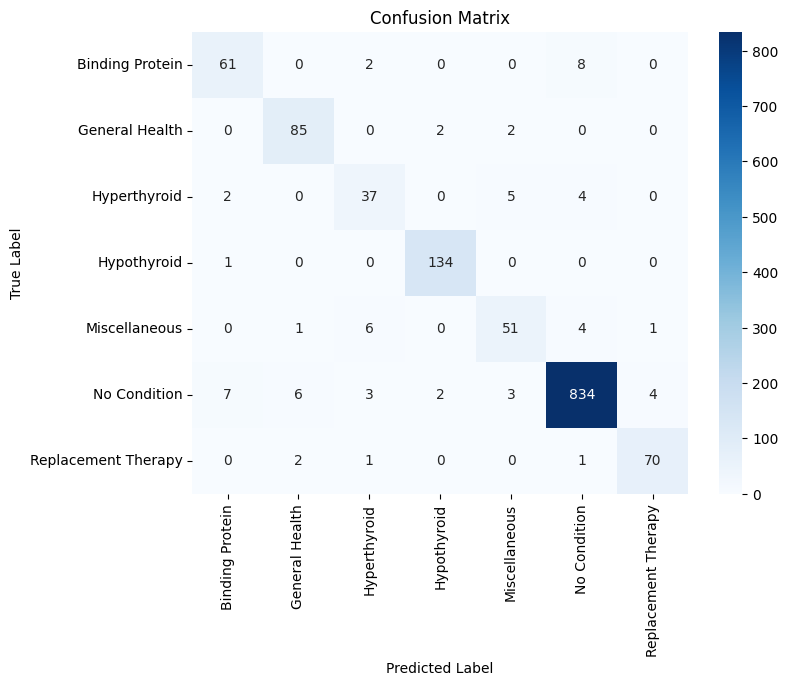

F2 Score for each class:
[0.85915493 0.94444444 0.76763485 0.98820059 0.81469649 0.97270819
 0.94339623]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.86      0.86      0.86        71
     General Health       0.90      0.96      0.93        89
       Hyperthyroid       0.76      0.77      0.76        48
        Hypothyroid       0.97      0.99      0.98       135
      Miscellaneous       0.84      0.81      0.82        63
       No Condition       0.98      0.97      0.98       859
Replacement Therapy       0.93      0.95      0.94        74

           accuracy                           0.95      1339
          macro avg       0.89      0.90      0.90      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93353249 0.94473488 0.94398805 0.94100075 0.88415546]

Decision Tree Classifier:
Confusion Matrix:


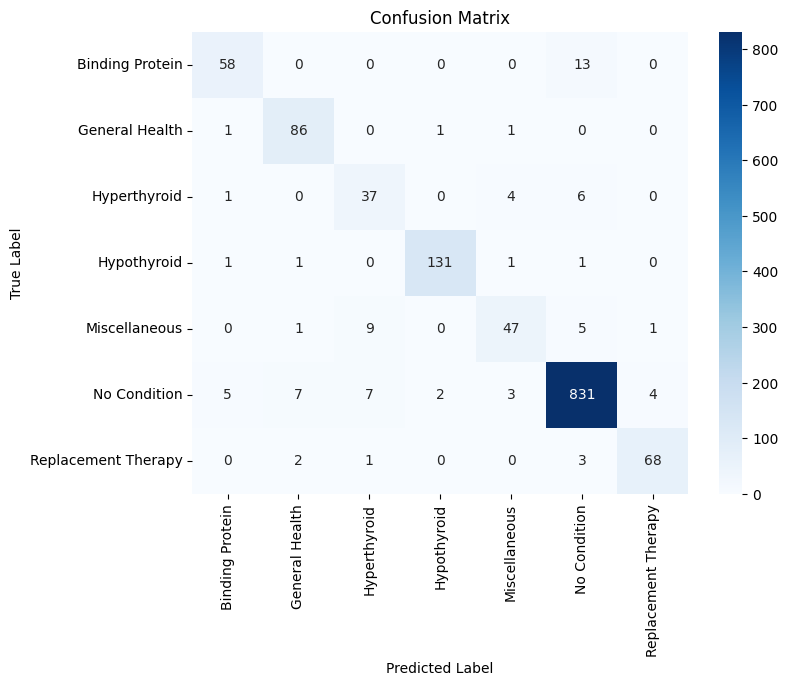

F2 Score for each class:
[0.82857143 0.94922737 0.75203252 0.97181009 0.76298701 0.96740396
 0.92140921]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.88      0.82      0.85        71
     General Health       0.89      0.97      0.92        89
       Hyperthyroid       0.69      0.77      0.73        48
        Hypothyroid       0.98      0.97      0.97       135
      Miscellaneous       0.84      0.75      0.79        63
       No Condition       0.97      0.97      0.97       859
Replacement Therapy       0.93      0.92      0.93        74

           accuracy                           0.94      1339
          macro avg       0.88      0.88      0.88      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92307692 0.93950709 0.92755788 0.91560866 0.35426009]


Random State: 40
Train set shape: (5355, 28), Test set shape: (1339, 28)
Best params for Random Forest: {'n_estima

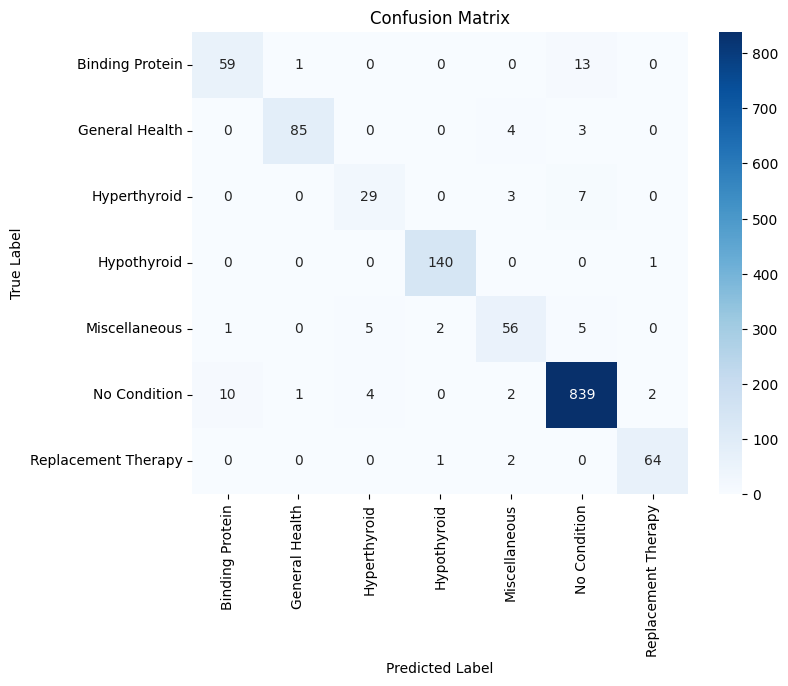

F2 Score for each class:
[0.81491713 0.93406593 0.74742268 0.99009901 0.81632653 0.97580833
 0.95522388]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.84      0.81      0.83        73
     General Health       0.98      0.92      0.95        92
       Hyperthyroid       0.76      0.74      0.75        39
        Hypothyroid       0.98      0.99      0.99       141
      Miscellaneous       0.84      0.81      0.82        69
       No Condition       0.97      0.98      0.97       858
Replacement Therapy       0.96      0.96      0.96        67

           accuracy                           0.95      1339
          macro avg       0.90      0.89      0.90      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.93353249 0.93950709 0.94324122 0.92681105 0.59491779]

Gradient Boosting Classifier:
Confusion Matrix:


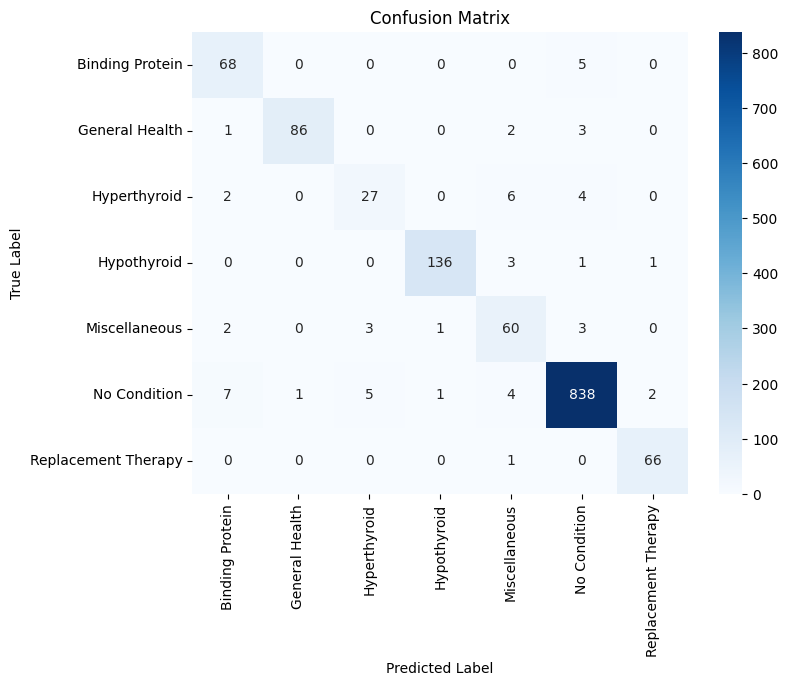

F2 Score for each class:
[0.91397849 0.94505495 0.70680628 0.96866097 0.85227273 0.97760149
 0.97922849]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.85      0.93      0.89        73
     General Health       0.99      0.93      0.96        92
       Hyperthyroid       0.77      0.69      0.73        39
        Hypothyroid       0.99      0.96      0.97       141
      Miscellaneous       0.79      0.87      0.83        69
       No Condition       0.98      0.98      0.98       858
Replacement Therapy       0.96      0.99      0.97        67

           accuracy                           0.96      1339
          macro avg       0.90      0.91      0.90      1339
       weighted avg       0.96      0.96      0.96      1339

Cross-validation Scores:
[0.94772218 0.94324122 0.94100075 0.92755788 0.89760837]

Decision Tree Classifier:
Confusion Matrix:


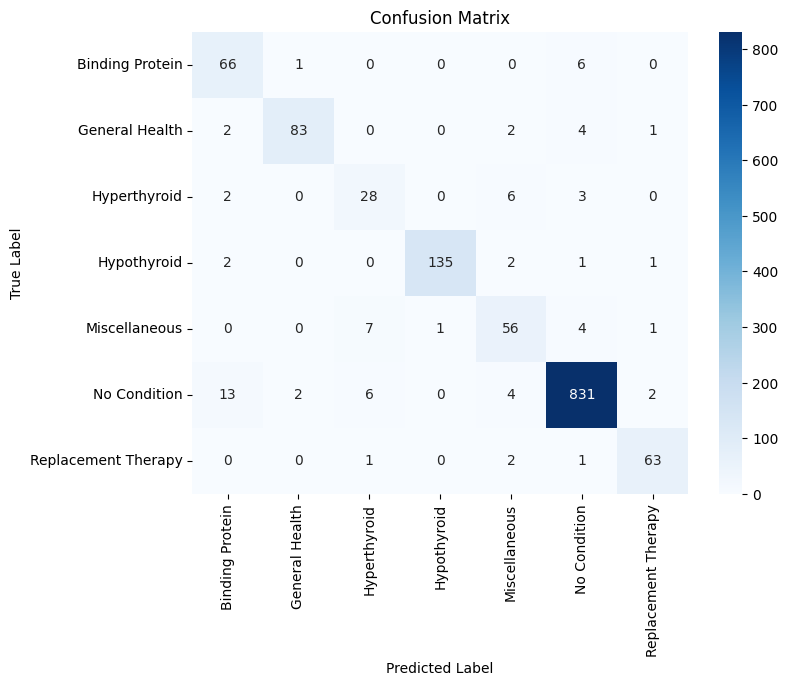

F2 Score for each class:
[0.87533156 0.91409692 0.70707071 0.96428571 0.8045977  0.97034096
 0.9375    ]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.78      0.90      0.84        73
     General Health       0.97      0.90      0.93        92
       Hyperthyroid       0.67      0.72      0.69        39
        Hypothyroid       0.99      0.96      0.97       141
      Miscellaneous       0.78      0.81      0.79        69
       No Condition       0.98      0.97      0.97       858
Replacement Therapy       0.93      0.94      0.93        67

           accuracy                           0.94      1339
          macro avg       0.87      0.89      0.88      1339
       weighted avg       0.95      0.94      0.94      1339

Cross-validation Scores:
[0.8334578  0.94100075 0.92905153 0.91038088 0.35500747]


Random State: 50
Train set shape: (5355, 28), Test set shape: (1339, 28)
Best params for Random Forest: {'n_estima

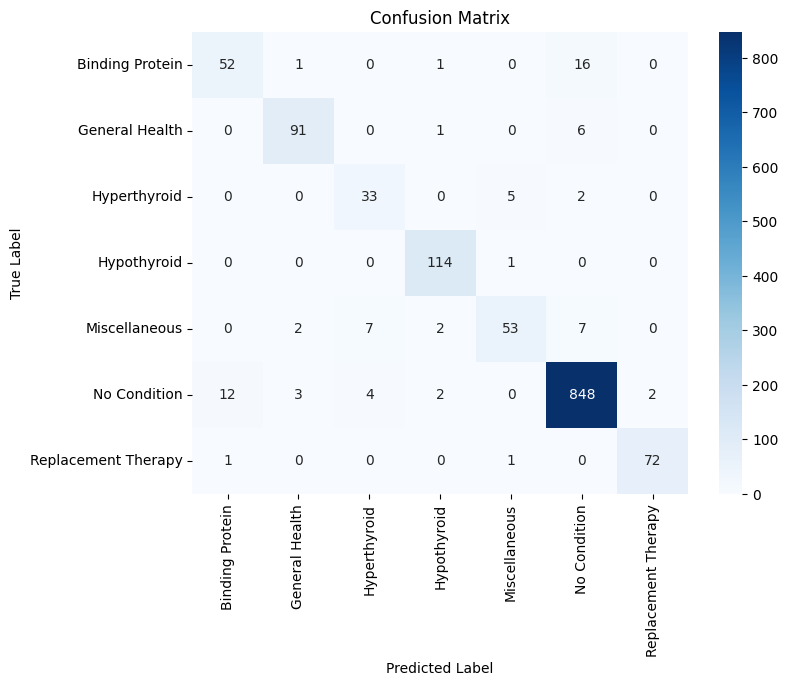

F2 Score for each class:
[0.75362319 0.93047035 0.80882353 0.98275862 0.77034884 0.97180839
 0.97297297]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.80      0.74      0.77        70
     General Health       0.94      0.93      0.93        98
       Hyperthyroid       0.75      0.82      0.79        40
        Hypothyroid       0.95      0.99      0.97       115
      Miscellaneous       0.88      0.75      0.81        71
       No Condition       0.96      0.97      0.97       871
Replacement Therapy       0.97      0.97      0.97        74

           accuracy                           0.94      1339
          macro avg       0.89      0.88      0.89      1339
       weighted avg       0.94      0.94      0.94      1339

Cross-validation Scores:
[0.92457058 0.94921583 0.9424944  0.92830471 0.57174888]

Gradient Boosting Classifier:
Confusion Matrix:


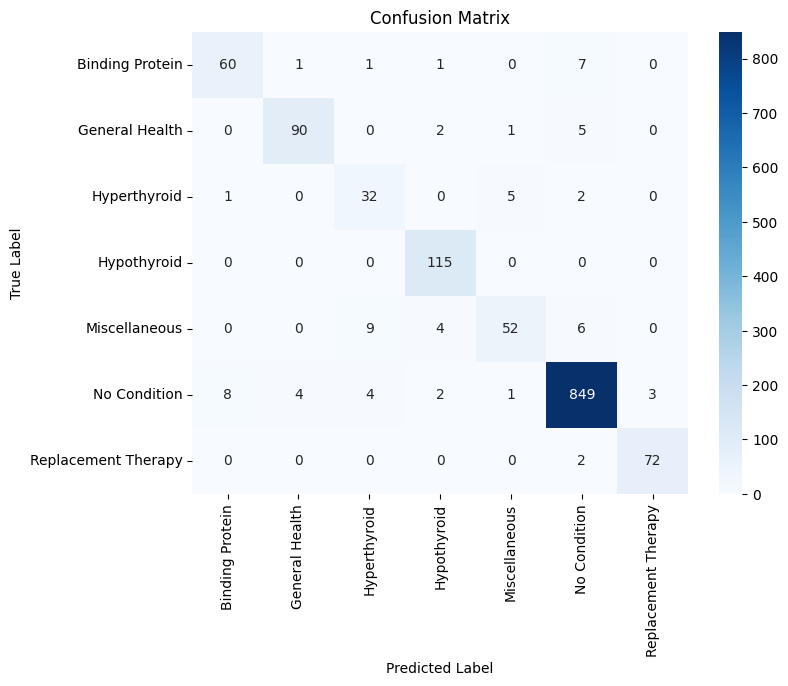

F2 Score for each class:
[0.85959885 0.92402464 0.77669903 0.98458904 0.75801749 0.97474168
 0.9703504 ]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.87      0.86      0.86        70
     General Health       0.95      0.92      0.93        98
       Hyperthyroid       0.70      0.80      0.74        40
        Hypothyroid       0.93      1.00      0.96       115
      Miscellaneous       0.88      0.73      0.80        71
       No Condition       0.97      0.97      0.97       871
Replacement Therapy       0.96      0.97      0.97        74

           accuracy                           0.95      1339
          macro avg       0.89      0.89      0.89      1339
       weighted avg       0.95      0.95      0.95      1339

Cross-validation Scores:
[0.92905153 0.94473488 0.94473488 0.93726662 0.88714499]

Decision Tree Classifier:
Confusion Matrix:


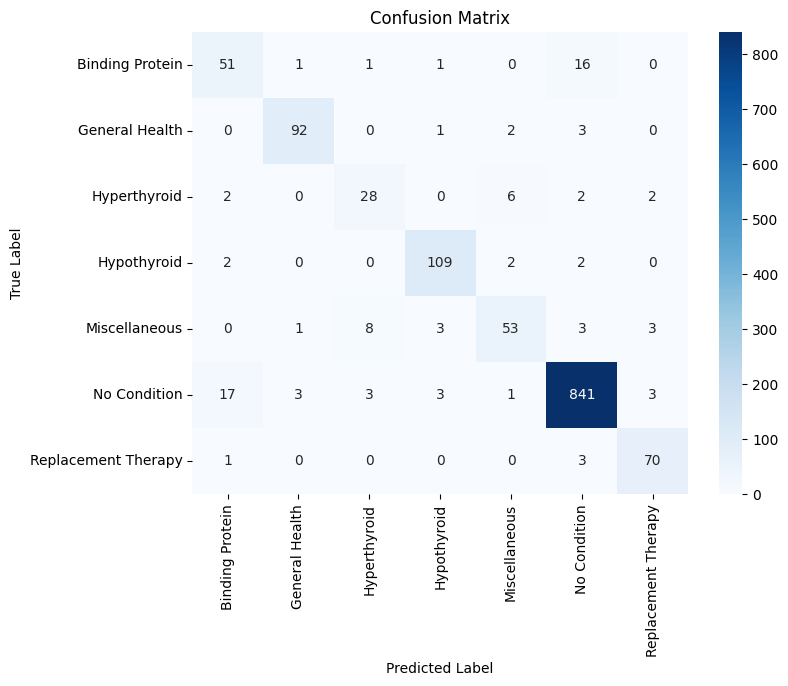

F2 Score for each class:
[0.7223796  0.9406953  0.7        0.94454073 0.76149425 0.96577859
 0.93582888]
Classification Report:
                     precision    recall  f1-score   support

    Binding Protein       0.70      0.73      0.71        70
     General Health       0.95      0.94      0.94        98
       Hyperthyroid       0.70      0.70      0.70        40
        Hypothyroid       0.93      0.95      0.94       115
      Miscellaneous       0.83      0.75      0.79        71
       No Condition       0.97      0.97      0.97       871
Replacement Therapy       0.90      0.95      0.92        74

           accuracy                           0.93      1339
          macro avg       0.85      0.85      0.85      1339
       weighted avg       0.93      0.93      0.93      1339

Cross-validation Scores:
[0.92830471 0.94174757 0.92905153 0.91560866 0.35724963]


Average Confusion Matrix for Random Forest Classifier:
[[5.760e+01 8.000e-01 8.000e-01 4.000e-01 0.000e+00 1.820e+

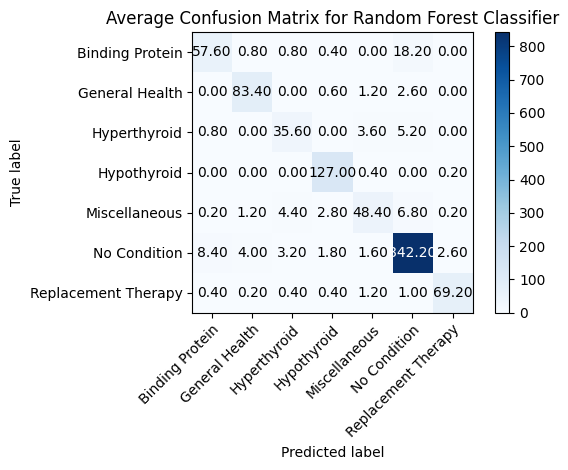

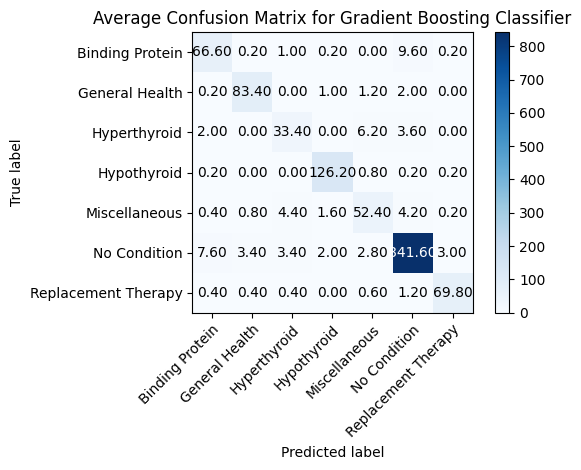

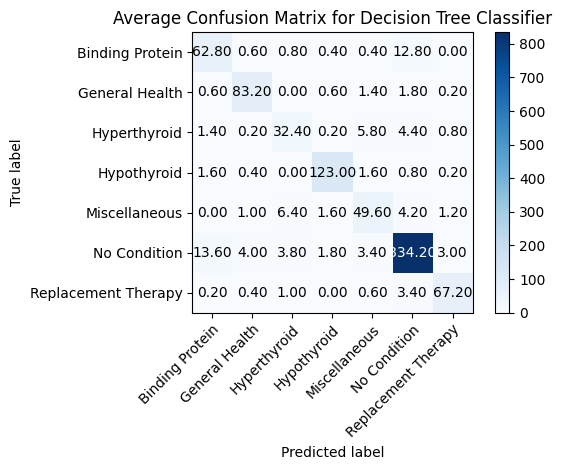

In [62]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

random_states = [10, 20, 30, 40, 50]

# Defining parameter grids for each classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_dt = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Accumulators for confusion matrices and F2 scores
conf_matrices_rf = []
conf_matrices_gb = []
conf_matrices_dt = []

f2_scores_rf = []
f2_scores_gb = []
f2_scores_dt = []

for state in random_states:
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    # Shapes of datasets
    print(f"Random State: {state}")
    print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Hyperparameter tuning for Random Forest Classifier
    grid_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=skf, scoring='accuracy', n_iter=10, random_state=42)
    grid_search_rf.fit(X_train, y_train)
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Best params for Random Forest: {grid_search_rf.best_params_}")
    print(f"Accuracy for Random Forest Classifier: {accuracy_rf}")

    # Hyperparameter tuning for Gradient Boosting Classifier
    grid_search_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=skf, scoring='accuracy', n_iter=10, random_state=42)
    grid_search_gb.fit(X_train, y_train)
    best_gb = grid_search_gb.best_estimator_
    y_pred_gb = best_gb.predict(X_test)
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    print(f"Best params for Gradient Boosting: {grid_search_gb.best_params_}")
    print(f"Accuracy for Gradient Boosting Classifier: {accuracy_gb}")

    # Hyperparameter tuning for Decision Tree Classifier
    grid_search_dt = RandomizedSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=skf, scoring='accuracy', n_iter=10, random_state=42)
    grid_search_dt.fit(X_train, y_train)
    best_dt = grid_search_dt.best_estimator_
    y_pred_dt = best_dt.predict(X_test)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Best params for Decision Tree: {grid_search_dt.best_params_}")
    print(f"Accuracy for Decision Tree Classifier: {accuracy_dt}")

    # Generating confusion matrix and calculate F1 and F2 scores for each class
    labels = np.unique(y_test)
    cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
    cm_gb = confusion_matrix(y_test, y_pred_gb, labels=labels)
    cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)

    f2_rf = fbeta_score(y_test, y_pred_rf, beta=2, average=None)
    f2_gb = fbeta_score(y_test, y_pred_gb, beta=2, average=None)
    f2_dt = fbeta_score(y_test, y_pred_dt, beta=2, average=None)

    # Appending the results to accumulators
    conf_matrices_rf.append(cm_rf)
    conf_matrices_gb.append(cm_gb)
    conf_matrices_dt.append(cm_dt)

    f2_scores_rf.append(f2_rf)
    f2_scores_gb.append(f2_gb)
    f2_scores_dt.append(f2_dt)

    print("\nRandom Forest Classifier:")
    print("Confusion Matrix:")

    plot_confusion_matrix(cm_rf, labels=np.unique(y))

    print("F2 Score for each class:")
    print(f2_rf)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_rf))
    print("Cross-validation Scores:")
    cv_scores_rf = cross_val_score(best_rf, X, y, cv=skf)
    print(cv_scores_rf)

    print("\nGradient Boosting Classifier:")
    print("Confusion Matrix:")

    plot_confusion_matrix(cm_gb, labels=np.unique(y))

    print("F2 Score for each class:")
    print(f2_gb)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_gb))
    print("Cross-validation Scores:")
    cv_scores_gb = cross_val_score(best_gb, X, y, cv=skf)
    print(cv_scores_gb)

    print("\nDecision Tree Classifier:")
    print("Confusion Matrix:")

    plot_confusion_matrix(cm_dt, labels=np.unique(y))

    print("F2 Score for each class:")
    print(f2_dt)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_dt))
    print("Cross-validation Scores:")
    cv_scores_dt = cross_val_score(best_dt, X, y, cv=skf)
    print(cv_scores_dt)
    print("\n")

# Calculating & printing the average confusion matrix and F2 score for each classifier
avg_cm_rf = np.mean(conf_matrices_rf, axis=0)
avg_cm_gb = np.mean(conf_matrices_gb, axis=0)
avg_cm_dt = np.mean(conf_matrices_dt, axis=0)

avg_f2_rf = np.mean(f2_scores_rf, axis=0)
avg_f2_gb = np.mean(f2_scores_gb, axis=0)
avg_f2_dt = np.mean(f2_scores_dt, axis=0)

print("Average Confusion Matrix for Random Forest Classifier:")
print(avg_cm_rf)
print("Average F2 Score for Random Forest Classifier:")
print(avg_f2_rf)

print("\nAverage Confusion Matrix for Gradient Boosting Classifier:")
print(avg_cm_gb)
print("Average F2 Score for Gradient Boosting Classifier:")
print(avg_f2_gb)

print("\nAverage Confusion Matrix for Decision Tree Classifier:")
print(avg_cm_dt)
print("Average F2 Score for Decision Tree Classifier:")
print(avg_f2_dt)



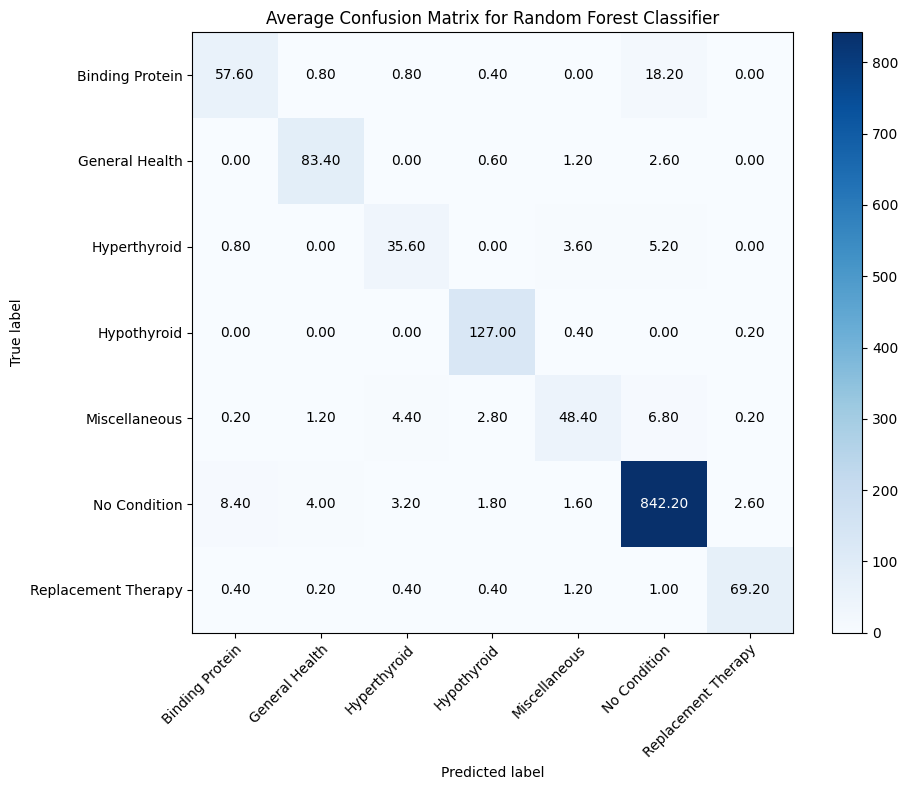

<Figure size 1400x1200 with 0 Axes>

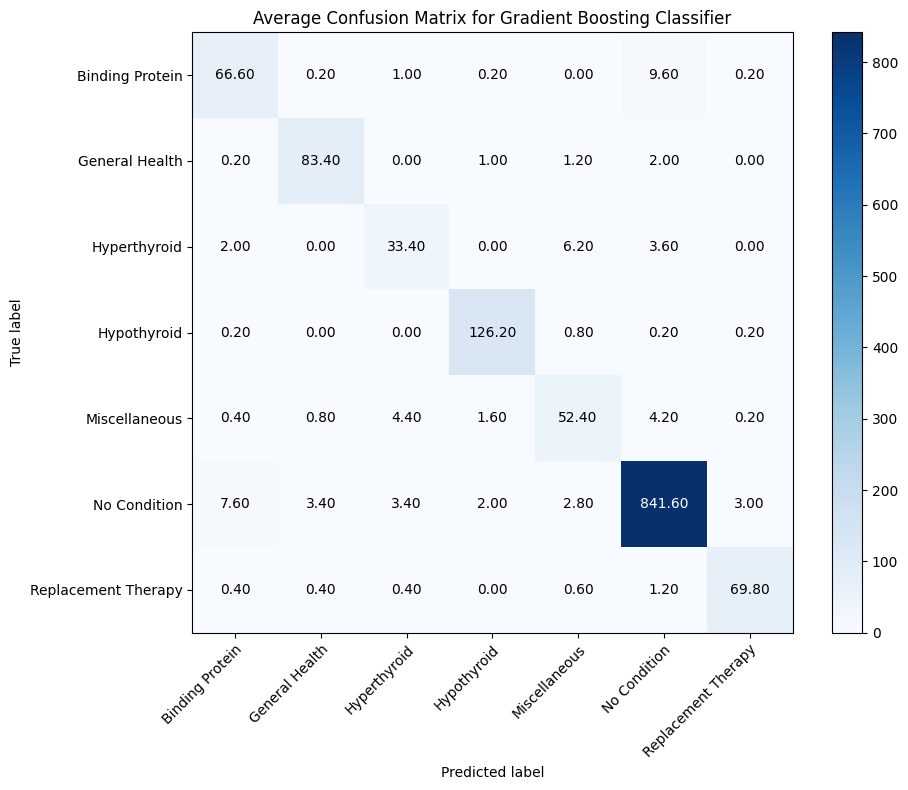

<Figure size 1400x1200 with 0 Axes>

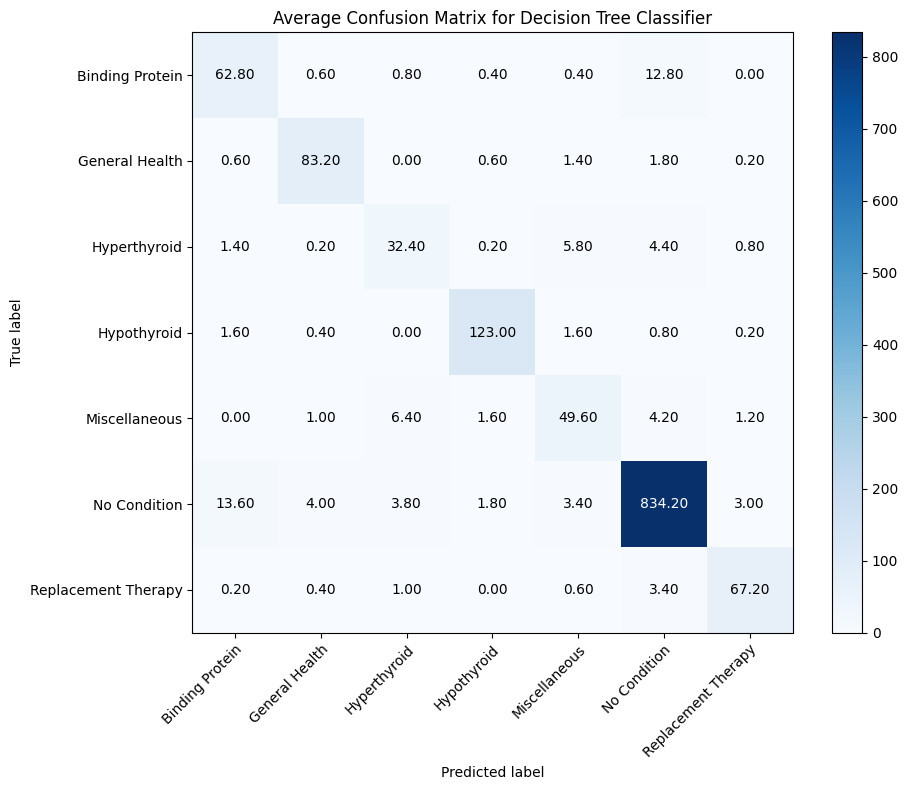

<Figure size 1400x1200 with 0 Axes>

In [76]:
# Plot the average confusion matrices
plot_avg_confusion_matrix(avg_cm_rf, labels, 'Average Confusion Matrix for Random Forest Classifier')
plot_avg_confusion_matrix(avg_cm_gb, labels, 'Average Confusion Matrix for Gradient Boosting Classifier')
plot_avg_confusion_matrix(avg_cm_dt, labels, 'Average Confusion Matrix for Decision Tree Classifier')
